# QMUGs_Data EDA

## Import packages

In [1]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# manipulate data
import pandas as pd
import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr
import numpy as np
import getpass, os

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

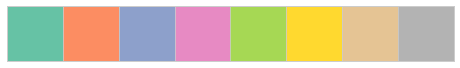

In [2]:
sns.palplot(pal)

In [3]:
# Import AMPL libraries
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jupyter/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [4]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

  Using cached llvmlite-0.35.0.tar.gz (121 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      running bdist_wheel
      /opt/conda/bin/python3.10 /var/tmp/pip-install-yrrtq4s2/llvmlite_d8e7d283451b4cd0af0de5e9a14a14c2/ffi/build.py
      LLVM version... Traceback (most recent call last):
        File "/var/tmp/pip-install-yrrtq4s2/llvmlite_d8e7d283451b4cd0af0de5e9a14a14c2/ffi/build.py", line 105, in main_posix
          out = subprocess.check_output([llvm_config, '--version'])
        File "/opt/conda/lib/python3.10/subprocess.py", line 421, in check_output
          return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
        File "/opt/conda/lib/python3.10/subprocess.py", line 503, in run
          with Popen(*popenargs, **kwargs) as process:
        File "/opt/conda/lib/python3.10/subprocess.py", line 971, in __init__
          sel

In [5]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2023-11-01 18:45:20--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh.8’

install_AMPL_GPU_te 100%[===================>]   1.10K  --.-KB/s    in 0s      

2023-11-01 18:45:21 (51.2 MB/s) - ‘install_AMPL_GPU_test.sh.8’ saved [1127/1127]

mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
error: pathspec 'deepchem_25' did not match any file(s) known to git
patch: **** Can't create temporary file /content/github/AMPL/atomsci/ddm/pipeline/transformations.py.oDNXl1N : No such file or directory
patch: **** Can't create temporary

## Load data

In [8]:
os.getcwd()

'/home/jupyter'

In [9]:
# load the dataset
data = pd.read_csv("qmugs_rdkit_smiles.csv", sep=',', header=0)

## Explore QMUGs Dataset

In [10]:
data.shape

(1992984, 70)

In [11]:
data.columns

Index(['Unnamed: 0', 'chembl_id', 'conf_id', 'smiles', 'mw', 'atoms',
       'heavy_atoms', 'heteroatoms', 'rotatable_bonds', 'stereocenters',
       'rings', 'hbond_acceptors', 'hbond_donors',
       'significant_negative_wavenumbers', 'nonunique_smiles',
       'GFN2_TOTAL_ENERGY', 'GFN2_ATOMIC_ENERGY', 'GFN2_FORMATION_ENERGY',
       'GFN2_TOTAL_ENTHALPY', 'GFN2_TOTAL_FREE_ENERGY', 'GFN2_DIPOLE_X',
       'GFN2_DIPOLE_Y', 'GFN2_DIPOLE_Z', 'GFN2_DIPOLE_TOT',
       'GFN2_QUADRUPOLE_XX', 'GFN2_QUADRUPOLE_XY', 'GFN2_QUADRUPOLE_YY',
       'GFN2_QUADRUPOLE_XZ', 'GFN2_QUADRUPOLE_yz', 'GFN2_QUADRUPOLE_ZZ',
       'GFN2_ROT_CONSTANT_A', 'GFN2_ROT_CONSTANT_B', 'GFN2_ROT_CONSTANT_C',
       'GFN2_ENTHALPY_VIB', 'GFN2_ENTHALPY_ROT', 'GFN2_ENTHALPY_TRANSL',
       'GFN2_ENTHALPY_TOT', 'GFN2_HEAT_CAPACITY_VIB', 'GFN2_HEAT_CAPACITY_ROT',
       'GFN2_HEAT_CAPACITY_TRANSL', 'GFN2_HEAT_CAPACITY_TOT',
       'GFN2_ENTROPY_VIB', 'GFN2_ENTROPY_ROT', 'GFN2_ENTROPY_TRANSL',
       'GFN2_ENTROPY_TOT', '

In [12]:
print(data["chembl_id"].value_counts())

CHEMBL1          3
CHEMBL3885331    3
CHEMBL3885292    3
CHEMBL3885294    3
CHEMBL3885298    3
                ..
CHEMBL3670973    1
CHEMBL3884092    1
CHEMBL560305     1
CHEMBL1453574    1
CHEMBL3780580    1
Name: chembl_id, Length: 665911, dtype: int64


In [13]:
d1 = data.pivot_table(index = 'chembl_id', columns = 'atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
display(d1.describe())

atoms,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,224,228
count,5.000000,2.000000,3.000000,4.000000,6.000000,12.000000,22.000000,32.000000,46.000000,75.000000,132.000000,225.000000,282.000000,404.000000,504.000000,607.000000,903.000000,1057.000000,1200.000000,1477.000000,2055.000000,2267.000000,3023.000000,3610.000000,4332.000000,4824.000000,5741.000000,6419.000000,7060.000000,7777.000000,8523.000000,9085.000000,9816.000000,11093.000000,11451.000000,12018.000000,12893.000000,13976.000000,14699.000000,15226.000000,16205.000000,16142.000000,16781.000000,17161.000000,17696.000000,...,56.000000,45.000000,45.000000,50.000000,48.000000,34.000000,40.000000,33.000000,43.000000,42.000000,25.000000,32.000000,56.000000,34.000000,43.000000,36.000000,31.000000,35.000000,44.000000,34.000000,40.000000,31.000000,33.000000,26.000000,18.000000,21.000000,15.000000,9.000000,17.000000,16.000000,9.000000,12.000000,5.000000,24.000000,10.000000,5.000000,6.000000,4.000000,2.000000,5.000000,4.000000,2.000000,2.000000,1.000000,2.000000
mean,0.202960,0.158214,0.122354,0.166414,0.183390,0.173947,0.170672,0.147360,0.124442,0.126710,0.125690,0.124086,0.116628,0.118820,0.113622,0.110560,0.112567,0.112783,0.110085,0.112230,0.110133,0.106478,0.103666,0.102400,0.102080,0.100552,0.099577,0.099235,0.099204,0.097677,0.097709,0.097395,0.096879,0.096030,0.096793,0.096441,0.095762,0.095677,0.095806,0.095713,0.095233,0.094527,0.095133,0.094777,0.095022,...,0.096666,0.099260,0.096861,0.099403,0.092609,0.094149,0.103211,0.090065,0.096316,0.097006,0.099249,0.102343,0.096376,0.096395,0.105757,0.106843,0.096552,0.113434,0.105531,0.103283,0.105183,0.109224,0.109112,0.107465,0.103198,0.108939,0.104949,0.104836,0.097705,0.103274,0.108159,0.104320,0.103777,0.104254,0.109638,0.098796,0.102479,0.105912,0.090338,0.118712,0.098197,0.104072,0.102404,0.114031,0.119855
std,0.038651,0.041967,0.094517,0.055238,0.107746,0.083303,0.074974,0.055650,0.045672,0.052771,0.054093,0.037362,0.040531,0.047310,0.034952,0.036957,0.046988,0.043963,0.038323,0.050068,0.045676,0.036193,0.036599,0.036802,0.032969,0.031465,0.030894,0.028352,0.029722,0.029073,0.028170,0.027492,0.026325,0.025278,0.026019,0.024975,0.024378,0.024370,0.024516,0.024011,0.024521,0.023750,0.023595,0.023074,0.023429,...,0.019532,0.019448,0.021605,0.021642,0.020941,0.020484,0.013510,0.025121,0.019361,0.019782,0.016914,0.017927,0.018933,0.020739,0.017276,0.020289,0.021983,0.016895,0.015574,0.015557,0.019534,0.014216,0.014554,0.013672,0.011116,0.017383,0.016645,0.014189,0.013048,0.011688,0.020155,0.013924,0.023276,0.014514,0.008719,0.013050,0.005941,0.008510,0.005252,0.021437,0.007294,0.019402,0.030391,NaN,0.013149
min,0.160939,0.128538,0.067212,0.103885,0.074231,0.057972,0.092601,0.047476,0.039292,0.024056,0.032569,0.053469,0.012251,0.036138,0.014047,0.017454,0.018536,0.015879,0.031920,0.026721,0.015705,0.005207,0.012733,0.012703,0.009761,0.012282,0.015997,0.010280,0.006830,0.003885,0.009508,0.006715,0.011730,0.010279,0.014184,0.006594,0.008157,0.007634,0.007279,0.005362,0.005725,0.007398,0.008058,0.007198,0.006780,...,0.031557,0.041941,0.006896,0.043020,0.043905,0.013848,0.042003,0.029091,0.030184,0.037519,0.037601,0.057981,0.051731,0.008356,0.074137,0.083465,0.044513,0.081793,0.077662,0.072809,0.066042,0.090311,0.081592,0.076945,0.088735,0.067554,0.062736,0.085589,0.075318,0.078322,0.083944,0.087543,0.076077,0.073821,0.092852,0.078366,0.093236,0.093630,0.086624,0.085874,0.089958,0.090353,0.080914,0.114031,0.110557
25%,0.163312,0.143376,0.067785,0.130921,0.103589,0.120048,0.128993,0.109055,0.101835,0.106324,0.093849,0.101422,0.093934,0.094752,0.091478,0.091239,0.085931,0.089142,0.089917,0.087247,0.086402,0.087081,0.084465,0.084605,0.085739,0.083392,0.083310,0.084176,0.082979

In [16]:
d2 = data.pivot_table(index = 'chembl_id', columns = 'atoms', values='DFT_HOMO_LUMO_GAP', aggfunc='mean')
display(d2.describe())

atoms,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,224,228
count,5.000000,2.000000,3.000000,4.000000,6.000000,12.000000,22.000000,32.000000,46.000000,75.000000,132.000000,225.000000,282.000000,404.000000,504.000000,607.000000,903.000000,1057.000000,1200.000000,1477.000000,2055.000000,2267.000000,3023.000000,3610.000000,4332.000000,4824.000000,5741.000000,6419.000000,7060.000000,7777.000000,8523.000000,9085.000000,9816.000000,11093.000000,11451.000000,12018.000000,12893.000000,13976.000000,14699.000000,15226.000000,16205.000000,16142.000000,16781.000000,17161.000000,17696.000000,...,56.000000,45.000000,45.000000,50.000000,48.000000,34.000000,40.000000,33.000000,43.000000,42.000000,25.000000,32.000000,56.000000,34.000000,43.000000,36.000000,31.000000,35.000000,44.000000,34.000000,40.000000,31.000000,33.000000,26.000000,18.000000,21.000000,15.000000,9.000000,17.000000,16.000000,9.000000,12.000000,5.000000,24.000000,10.000000,5.000000,6.000000,4.000000,2.000000,5.000000,4.000000,2.000000,2.000000,1.00000,2.000000
mean,0.447196,0.401553,0.368677,0.414667,0.410994,0.394252,0.402533,0.381515,0.355655,0.346994,0.353515,0.341465,0.333863,0.338891,0.329184,0.323012,0.327532,0.325284,0.322771,0.323163,0.319700,0.316906,0.312790,0.310288,0.309110,0.307109,0.306070,0.305382,0.305059,0.303686,0.303584,0.302811,0.302922,0.302048,0.302180,0.302096,0.301567,0.301295,0.301284,0.301977,0.301218,0.300333,0.301379,0.301021,0.301418,...,0.320649,0.319989,0.314548,0.322952,0.315713,0.311804,0.326966,0.313766,0.324336,0.319134,0.328183,0.330212,0.323068,0.328364,0.336397,0.336841,0.324851,0.346742,0.338059,0.332173,0.335625,0.342510,0.341017,0.337353,0.339535,0.338591,0.339232,0.339200,0.333505,0.332147,0.348139,0.339594,0.341262,0.348416,0.346264,0.348648,0.338363,0.330542,0.321036,0.355513,0.321402,0.338057,0.350972,0.36233,0.363396
std,0.031505,0.049434,0.114535,0.042065,0.080050,0.050039,0.057758,0.056967,0.051743,0.039326,0.051335,0.041264,0.041400,0.045200,0.039384,0.037149,0.042894,0.042669,0.038570,0.042447,0.039868,0.037398,0.036529,0.035720,0.032845,0.034002,0.034175,0.031477,0.033351,0.033163,0.031614,0.031187,0.031234,0.030316,0.029903,0.029469,0.028867,0.028377,0.028373,0.028655,0.028312,0.027660,0.027846,0.027338,0.027610,...,0.026652,0.030231,0.028489,0.029481,0.021984,0.025724,0.019960,0.037423,0.021547,0.029725,0.018234,0.021274,0.024333,0.026223,0.018536,0.026182,0.033526,0.016685,0.018020,0.023935,0.025078,0.013869,0.018657,0.015300,0.013467,0.022316,0.017544,0.016019,0.013847,0.019083,0.016437,0.014971,0.019199,0.010895,0.007918,0.012812,0.009389,0.018414,0.007204,0.025574,0.005368,0.020626,0.045787,NaN,0.015823
min,0.412357,0.366598,0.302398,0.372746,0.317170,0.289635,0.318633,0.277075,0.239593,0.258885,0.242761,0.250841,0.235578,0.255234,0.240778,0.231364,0.239249,0.218276,0.224708,0.226672,0.219055,0.193591,0.204508,0.184737,0.203321,0.208344,0.207431,0.211547,0.193924,0.149772,0.188901,0.177370,0.192731,0.200715,0.196691,0.197608,0.204095,0.187960,0.178991,0.193340,0.194790,0.185413,0.196212,0.196845,0.145739,...,0.227581,0.219563,0.188410,0.226586,0.270753,0.222628,0.261339,0.213227,0.269774,0.207310,0.269152,0.278888,0.263232,0.211680,0.301470,0.275256,0.245990,0.311104,0.283013,0.271875,0.276742,0.317571,0.291997,0.303992,0.319367,0.289247,0.309108,0.316066,0.303222,0.294998,0.325572,0.321329,0.308890,0.327714,0.333100,0.328379,0.322664,0.310070,0.315943,0.314651,0.317306,0.323473,0.318595,0.36233,0.352207
25%,0.417526,0.384076,0.302550,0.388108,0.348460,0.373192,0.360203,0.332055,0.327503,0.328380,0.312741,0.318210,0.308438,0.308022,0.303037,0.298612,0.297133,0.294913,0.294559,0.294816,0.292275,0.292378,0.288398,0.287436,0.287893,0.284378,0.284236,0.285088,0.282983,0.

## QMUGs Curation

Objective: Create histogram plots or distribution plots of the HOMO-LUMO gap values from GFN2 and DFT columns (separately).

To do this you can adjust the number of bins being calculated. What we are looking for are peaks present within the data as seen in the publications when plotting the number of compounds vs the GAP values.

In [ ]:
# canonicalize smiles strings 
data['rdkit_smile'] = data['smiles'].apply(curate_data.base_smiles_from_smiles)

In [ ]:
data['inchi_key'] = data['smiles'].apply(struct_utils.smiles_to_inchi_key)

In [ ]:
data['compound_id'] = data['inchi_key']

In [ ]:
data.head(6)

In [ ]:
data.to_csv("qmugs_rdkit_smiles.csv", index = False)

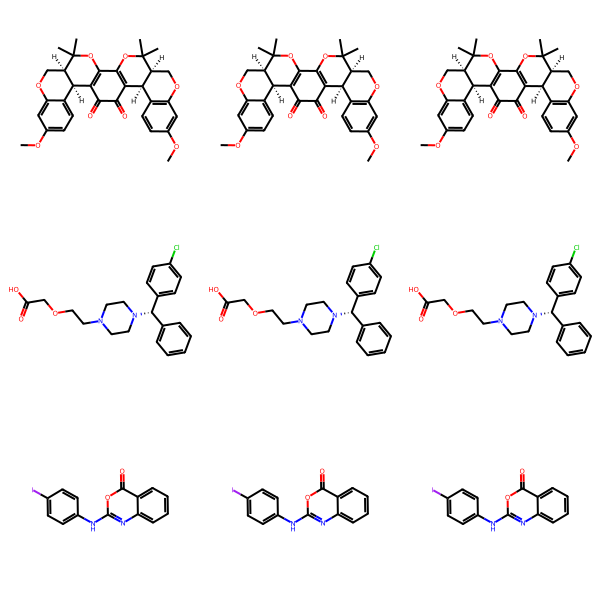

In [27]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice

molecules = [Chem.MolFromSmiles(smiles) for smiles in islice(data['smiles'], 9)]

Draw.MolsToGridImage(molecules)

In [28]:
# check if there is na value
na_value1 = data["GFN2_HOMO_LUMO_GAP"].isna().any()
na_value2 = data["DFT_HOMO_LUMO_GAP"].isna().any()
print(na_value1, na_value2)

False False


In [29]:
# look at length of dataset and duplicates.
print('Name duplicates:', data['compound_id'].duplicated().sum())
print('SMILES duplicates:', data.smiles.duplicated().sum())
print('Shape:', data.shape)

Name duplicates: 1334946
SMILES duplicates: 1333797
Shape: (1992984, 70)


In [ ]:
# column: Response values column
column = 'GFN2_HOMO_LUMO_GAP'

# tolerance: Percentage of individual respsonse values allowed to be different 
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smile'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case
 

curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                       max_std, 
                                                       compound_id = compound_id, 
                                                       smiles_col = smiles_col)

In [31]:
# column: Response values column
column = 'DFT_HOMO_LUMO_GAP'

# tolerance: Percentage of individual respsonse values allowed to be different 
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smile'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case
 

curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                       max_std, 
                                                       compound_id = compound_id, 
                                                       smiles_col = smiles_col)

Bad duplicates removed from dataset
Dataframe size (1992073, 74)
List of 'bad' duplicates removed
                         compound_id  DFT_HOMO_LUMO_GAP  VALUE_NUM_mean  \
15777    AACWENFRCBQJKI-MRXNPFEDSA-N           0.265005        0.307545   
446111   AAPVOSBVTLGGOU-VHUAAIQRSA-N           0.214953        0.248401   
629553   AAYBCINOWIIZPS-ZSWXBHCYSA-N           0.269089        0.243051   
347938   AAZRQCBNNOOVFU-OLZOCXBDSA-N           0.311953        0.267241   
973671   ABIHLEYEGKUFDJ-UIRBXLFWSA-N           0.337873        0.300508   
...                              ...                ...             ...   
14397    ZWWMEDURALZMEV-NSHDSACASA-N           0.278284        0.244577   
14396    ZWWMEDURALZMEV-NSHDSACASA-N           0.210871        0.244577   
1873122  ZXJOORMPCRZDRS-OALUTQOASA-N           0.337606        0.302157   
1008376  ZXNJFMYNNXCBLV-KFSUBKAUSA-N           0.306928        0.342859   
480793   ZZLTYWIQWSLERQ-IYNXWWQISA-N           0.295277        0.258436   

 

In [6]:
curated_df = pd.read_csv("curated_qmugs_data.csv", sep=',', header=0)

In [12]:
curated_df.shape

(659180, 73)

In [34]:
curated_df.head()

,chembl_id,conf_id,smiles,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,significant_negative_wavenumbers,nonunique_smiles,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,rdkit_smile,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL1,conf_00,[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])OC([H])...,544.209718,72,40,8,8,4,7,8,0,False,False,-117.426790,-100.117788,-17.309002,-116.820431,-116.920184,-2.618,-5.658,-3.467,7.134,7.227,3.615,11.107,3.188,-21.116,-18.335,0.004667,0.001914,0.001602,20783.593,888.752,1481.254,23153.599,136.843,2.981,4.968,144.792,127.233,37.965,44.750,209.947,-0.370232,-0.325308,0.044924,-0.347627,57856.896739,367.965458,-1838.542026,-1825.432388,-13.109638,-2.323990,-4.666405,-2.877058,5.954303,0.004576,0.001899,0.001602,-175.593881,4799.908504,-12057.970923,5595.187765,-0.285599,-0.042669,0.242930,COc1ccc2c(c1)OC[C@H]1[C@@H]2C2=C(OC1(C)C)C1=C(...,GHBOEFUAGSHXPO-XZOTUCIWSA-N,0.242102,0.000833,0.341925,0
1,CHEMBL1000,conf_00,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,52,27,6,8,1,3,5,1,False,False,-80.315048,-68.493287,-11.821760,-79.870590,-79.950811,2.379,-3.195,4.509,6.017,5.337,-25.657,-4.502,-1.798,11.798,-0.835,0.009034,0.002935,0.002678,14005.394,888.752,1481.254,16375.401,91.382,2.981,4.968,99.331,88.721,36.373,43.746,168.840,-0.352364,-0.237194,0.115170,-0.294779,31094.695246,272.494292,-1609.322700,-1600.285930,-9.036771,2.142420,-2.785717,4.253252,5.517276,0.008840,0.002865,0.002636,-132.809395,2659.135307,-7485.087002,3349.488535,-0.296513,0.044311,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0
2,CHEMBL10000,conf_00,[H]c1c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H...,363.970876,28,19,5,2,0,3,4,1,False,False,-52.393036,-45.173987,-7.219049,-52.180530,-52.241437,-1.362,0.292,0.020,1.394,-14.034,-36.284,0.606,-4.581,-2.685,13.428,0.027951,0.002706,0.002467,8093.824,888.752,1481.254,10463.830,54.575,2.981,4.968,62.524,49.224,35.414,43.551,128.189,-0.392061,-0.285465,0.106596,-0.338763,15494.797760,200.975607,-1095.832353,-1090.450449,-5.381904,-0.349732,0.940967,0.138212,1.013328,0.027875,0.002163,0.002008,-91.786777,1456.814354,-4495.141648,2034.299009,-0.292609,0.000486,0.293095,O=c1oc(Nc2ccc(I)cc2)nc2ccccc12,KXLZEFPIBPQEAU-UHFFFAOYSA-N,0.289124,0.003439,1.373521,0
3,CHEMBL100003,conf_00,[H]O/C(OC([H])([H])[H])=C1\C(C([H])([H])[H])=N...,281.162708,43,20,5,11,1,1,5,1,False,False,-63.044635,-53.625801,-9.418834,-62.664873,-62.740190,-4.793,-0.892,0.956,4.970,29.019,4.478,-8.898,-11.014,-3.925,-20.121,0.017387,0.007241,0.006572,12871.935,888.752,1481.254,15241.942,78.134,2.981,4.968,86.083,81.802,33.934,42.782,158.518,-0.350243,-0.270147,0.080096,-0.310195,16751.288449,195.140373,-940.100277,-932.957960,-7.142316,-4.986451,-0.869709,2.092616,5.477238,0.017294,0.007228,0.006575,-90.337873,1704.654877,-4667.691840,2113.309805,-0.263692,0.011718,0.275410,CCC[C@@H]1C(C(=O)OCC)=C(C)N=C(C)/C1=C(\

In [13]:
curated_df.to_csv("curated_qmugs_data.csv", index=False)

## Visualize distribution of molecular weights

In [ ]:
curated_df = pd.read_csv("columbia_select_qmugs_data_selected.csv", sep=',')

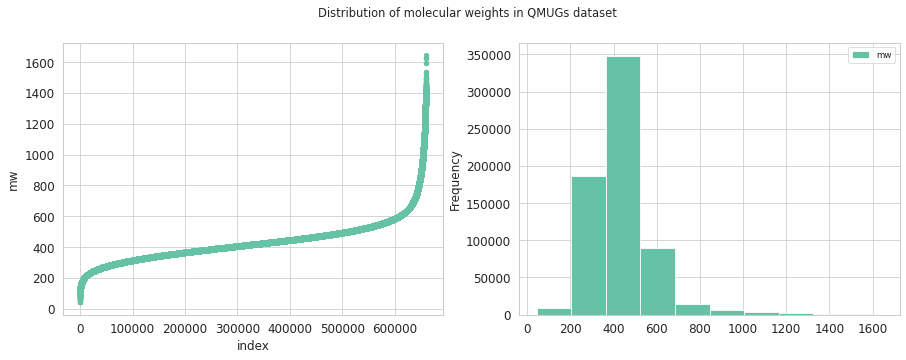

In [14]:
plot_df = curated_df
plot_df = plot_df.sort_values(by = 'mw')
plot_df = plot_df.reset_index(drop = True)
plot_df = plot_df.reset_index()

fig,ax = plt.subplots(1,2, figsize = (15,5))
plot_df.plot(kind = 'scatter', x = 'index', y = 'mw', color = pal[0], ax = ax[0])
plot_df.plot(kind = 'hist', x = "index", y = "mw", color = pal[0], ax = ax[1])
fig.suptitle("Distribution of molecular weights in QMUGs dataset");

heavy_atoms,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
count,7.000000,10.000000,28.000000,52.000000,122.000000,242.000000,406.000000,630.000000,1139.000000,1667.000000,2203.000000,3137.000000,4250.000000,5793.000000,7864.000000,10609.000000,12907.000000,16006.000000,18438.000000,21699.000000,24385.000000,26835.000000,29375.000000,31946.000000,33766.000000,35227.000000,35674.000000,35888.000000,35230.000000,33211.000000,30488.000000,27597.000000,24389.000000,20978.000000,18272.000000,15784.000000,13121.000000,10966.000000,9236.000000,7750.000000,6400.000000,5543.000000,4392.000000,3736.000000,2947.000000,...,961.000000,833.000000,881.000000,752.000000,833.000000,718.000000,708.000000,591.000000,566.000000,533.000000,530.000000,366.000000,414.000000,331.000000,362.000000,323.000000,338.000000,312.000000,320.000000,276.000000,325.000000,260.000000,279.000000,247.000000,219.000000,184.000000,180.000000,171.000000,196.000000,180.000000,178.000000,133.000000,149.000000,106.000000,138.000000,116.000000,112.000000,102.000000,126.000000,114.000000,106.000000,80.000000,97.000000,108.000000,101.000000
mean,0.209328,0.183004,0.183512,0.173781,0.165324,0.156093,0.157546,0.153481,0.142489,0.129777,0.125115,0.119910,0.114565,0.111051,0.107690,0.104911,0.102888,0.101640,0.100440,0.098721,0.097647,0.096939,0.096421,0.096408,0.095195,0.095003,0.094176,0.093552,0.092671,0.091724,0.091126,0.090069,0.089616,0.089039,0.088815,0.088917,0.088789,0.088721,0.089014,0.089418,0.088997,0.090162,0.090708,0.091147,0.090831,...,0.094656,0.094748,0.093634,0.089618,0.087169,0.085738,0.085232,0.084374,0.086560,0.087037,0.092162,0.090249,0.093031,0.097689,0.098330,0.101907,0.100942,0.100136,0.099422,0.103601,0.098329,0.099879,0.098846,0.099274,0.094535,0.098513,0.096761,0.099675,0.099775,0.101263,0.097719,0.098175,0.096536,0.099055,0.097449,0.098364,0.096202,0.092877,0.094806,0.097521,0.097782,0.100840,0.091446,0.094449,0.093297
std,0.078247,0.093944,0.067159,0.067468,0.068404,0.068602,0.075088,0.073291,0.067370,0.051883,0.050251,0.044232,0.038167,0.033506,0.032354,0.029247,0.028295,0.028006,0.028026,0.026375,0.025354,0.024289,0.024072,0.024414,0.023692,0.023419,0.023062,0.023169,0.022564,0.022564,0.022330,0.023063,0.022547,0.022415,0.022442,0.022920,0.023504,0.024117,0.023875,0.024468,0.024716,0.025768,0.026651,0.026499,0.027820,...,0.029465,0.027854,0.029754,0.031363,0.031162,0.032776,0.034239,0.034755,0.034031,0.032780,0.031901,0.033531,0.028729,0.026911,0.027476,0.024016,0.023867,0.023334,0.021719,0.025523,0.023617,0.029207,0.026094,0.022214,0.025290,0.023578,0.024234,0.026657,0.022119,0.028922,0.024747,0.024029,0.021565,0.021286,0.019602,0.021821,0.024952,0.022101,0.020873,0.017018,0.017579,0.018916,0.022544,0.021720,0.021544
min,0.129089,0.068348,0.087366,0.072152,0.047467,0.024117,0.037863,0.038613,0.032575,0.037520,0.017580,0.012256,0.005413,0.015653,0.013808,0.012835,0.013824,0.008684,0.006591,0.002973,0.003590,0.007135,0.006889,0.006241,0.007188,0.006406,0.003694,0.005984,0.005355,0.003062,0.005726,0.005763,0.005687,0.003365,0.004154,0.007822,0.004683,0.008857,0.007324,0.006458,0.007343,0.007108,0.007815,0.006185,0.004728,...,0.005598,0.017957,0.006271,0.006795,0.009015,0.009797,0.009398,0.006766,0.005685,0.009624,0.006032,0.007122,0.007082,0.012486,0.009546,0.008347,0.007975,0.011156,0.010140,0.004827,0.012381,0.007983,0.004242,0.009089,0.006051,0.010426,0.005977,0.007044,0.012801,0.005968,0.008487,0.019648,0.024335,0.039798,0.043131,0.021460,0.007865,0.030529,0.012302,0.005424,0.035924,0.016435,0.030923,0.012390,0.027515
25%,0.162229,0.114337,0.145315,0.135146,0.127092,0.123596,0.114994,0.113580,0.108582,0.105129,0.101630,0.098420,0.094193,0.093741,0.090048,0.088345,0.087119,0.085847,0.084627,0.083228,0.082904,0.082622,0.082139,0

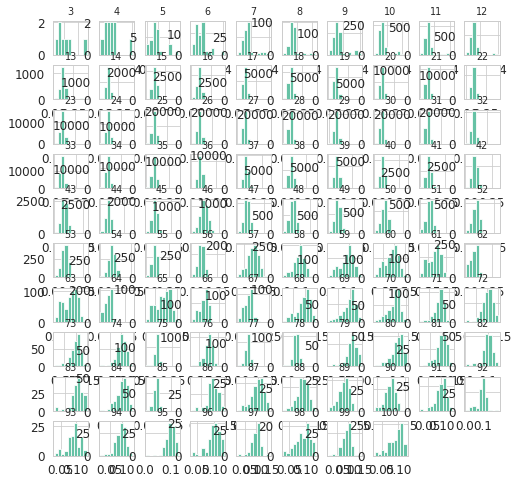

In [15]:
# examine standard values and GFN2 HOMO-LUMO GAP values PER type
data_types = curated_df.pivot_table(index = 'compound_id', columns = 'heavy_atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
display(data_types.describe())
data_types.hist(figsize=(8,8))
plt.show()

In [16]:
# examine standard values and DFT HOMO-LUMO GAP values PER type
data_types = data.pivot_table(index = 'compound_id', columns = 'chembl_id', values='DFT_HOMO_LUMO_GAP', aggfunc='mean')
display(data_types.describe())
data_types.hist(figsize=(8,8))
plt.show()

KeyboardInterrupt: 

## Compare HOMO-LUMO Gap Values across GFN2 and DFT

In [7]:
curated_df = pd.read_csv("curated_qmugs_data.csv", sep = ',', header=0)

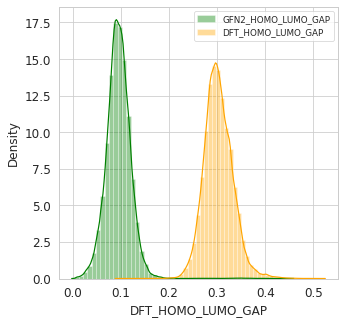

In [8]:
fig, ax = plt.subplots(figsize = (5,5))
sns.distplot(curated_df.GFN2_HOMO_LUMO_GAP, ax=ax, color = "green", label='GFN2_HOMO_LUMO_GAP')
sns.distplot(curated_df.DFT_HOMO_LUMO_GAP, ax=ax, color = "orange", label='DFT_HOMO_LUMO_GAP')
ax.legend()
plt.show()

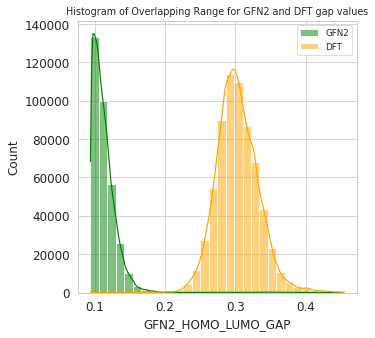

In [9]:
# Determine the minimum and maximum values of the overlap range
overlap_min = max(curated_df['GFN2_HOMO_LUMO_GAP'].min(), curated_df['DFT_HOMO_LUMO_GAP'].min())
overlap_max = min(curated_df['GFN2_HOMO_LUMO_GAP'].max(), curated_df['DFT_HOMO_LUMO_GAP'].max())

plt.figure(figsize=(5, 5))

# Plot the histograms for gfn2 and dft values within the overlap range
sns.histplot(curated_df[(curated_df['GFN2_HOMO_LUMO_GAP'] >= overlap_min) & (curated_df['GFN2_HOMO_LUMO_GAP'] <= overlap_max)]['GFN2_HOMO_LUMO_GAP'], 
             kde=True, bins=30, label='GFN2', color='green', alpha=0.5)

sns.histplot(curated_df[(curated_df['DFT_HOMO_LUMO_GAP'] >= overlap_min) & (curated_df['DFT_HOMO_LUMO_GAP'] <= overlap_max)]['DFT_HOMO_LUMO_GAP'], 
             kde=True, bins=30, label='DFT', color='orange', alpha=0.5)

plt.title('Histogram of Overlapping Range for GFN2 and DFT gap values')
plt.legend()
plt.show()

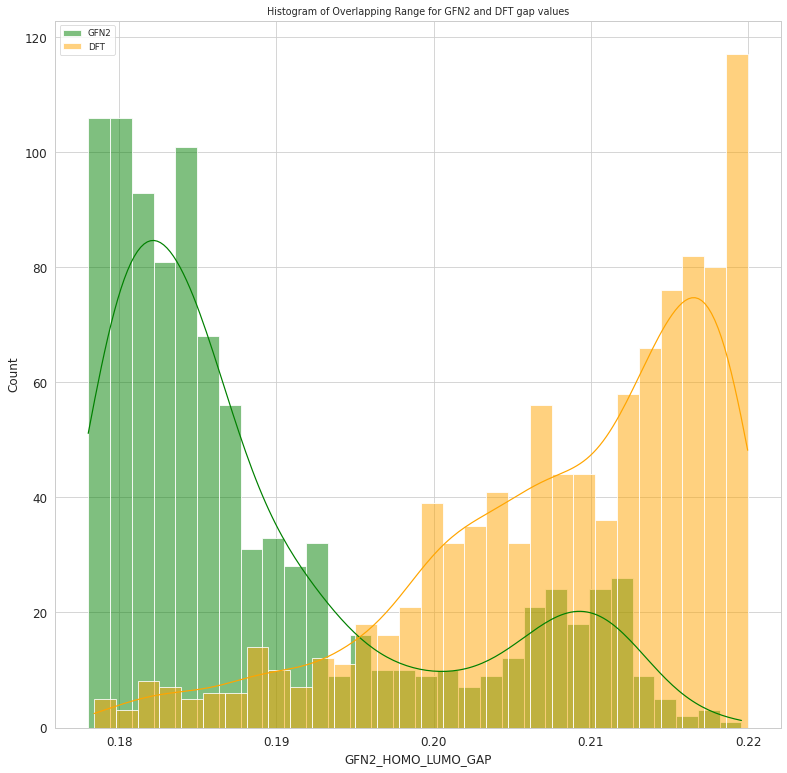

In [12]:
# adjust the region to capture the overlap of two gap values
overlap_start = 0.178
overlap_end = 0.22

plt.figure(figsize=(13, 13))

# Plot the histograms for gfn2 and dft values within the overlap range
sns.histplot(curated_df[(curated_df['GFN2_HOMO_LUMO_GAP'] >= overlap_start) & (curated_df['GFN2_HOMO_LUMO_GAP'] <= overlap_end)]['GFN2_HOMO_LUMO_GAP'], 
             kde=True, bins=30, label='GFN2', color='green', alpha=0.5)

sns.histplot(curated_df[(curated_df['DFT_HOMO_LUMO_GAP'] >= overlap_start) & (curated_df['DFT_HOMO_LUMO_GAP'] <= overlap_end)]['DFT_HOMO_LUMO_GAP'], 
             kde=True, bins=30, label='DFT', color='orange', alpha=0.5)

plt.title('Histogram of Overlapping Range for GFN2 and DFT gap values')
plt.legend()
plt.show()

In [11]:
overlap = curated_df[(curated_df['GFN2_HOMO_LUMO_GAP'] >= overlap_start) & (curated_df['GFN2_HOMO_LUMO_GAP'] <= overlap_end)]['GFN2_HOMO_LUMO_GAP']
overlap.describe()

count    960.000000
mean       0.188866
std        0.010392
min        0.178026
25%        0.181142
50%        0.184779
75%        0.192691
max        0.219581
Name: GFN2_HOMO_LUMO_GAP, dtype: float64

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(curated_df.GFN2_HOMO_LUMO_GAP, ax=ax, color = "green")
plt.title('Histogram of for GFN2 gap values')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(curated_df.DFT_HOMO_LUMO_GAP, ax=ax, color = "orange")
plt.title('Histogram for DFT gap values')
plt.show()

In [ ]:
dp.diversity_plots(dset_key='curated_qmugs_data.csv',
                   datastore=False, 
                   id_col ='compound_id', 
                   smiles_col = 'rdkit_smile', 
                   is_base_smiles=True, 
                   response_col = 'mw')

## Number of Atoms and Gap Values

Focus on looking at the number of rings, heavy atom count, and molecular weight.

Determine the different thresholds (25%, 50%, 75%, median, average, etc.) of these different molecule properties and make separate dataframes. You can then plot these groupings in similar plots as you had made for the entirety of the dataset to determine if there are trends we are seeing depending on the gap values. Make sure your labels as you prepare the dataframes are easy to follow so you do not get confused, the number of groupings you are working with it is easy to do. 

### Seperating numbers of atoms each compound has by quantiles into smaller dataset accordingly.

In [8]:
curated_df.describe()

,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
count,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,6.591800e+05,6.591800e+05,659180.000000,659180.000000,6.591800e+05,6.591800e+05,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,659180.000000,6.561710e+05,659180.000000,659180.0
mean,432.990678,55.223975,30.626933,7.979215,8.213772,1.025561,3.801509,5.612896,1.885317,-89.512437,-76.528037,-12.984399,-89.049457,-89.137260,-0.229205,-0.031158,0.007808,5.155606,0.102342,0.067789,-0.212657,-0.012860,-0.016994,0.110316,0.040254,0.003415,0.002813,16428.167920,8.887520e+02,1.481254e+03,18798.174195,104.753304,2.981000e+00,4.968000e+00,112.702344,104.189823,36.668098,43.939005,184.796926,-0.366290,-0.271393,0.094898,-0.318841,40563.259647,297.288687,-1744.006236,-1734.199064,-9.807173,-0.186515,-0.018393,0.008468,4.658362,0.011534,0.003330,0.002745,-146.363948,3289.891547,-8927.608058,4040.123878,-0.288595,0.014247,0.302842,0.302869,4.270711e-03,1.037357,0.0
std,136.832392,19.784064,9.683783,3.621414,5.165031,1.811195,1.334613,2.532615,1.902735,29.725575,25.461687,4.418583,29.561377,29.582258,3.689960,3.184900,2.998601,2.495703,21.460469,16.526976,15.300898,15.657899,10.241811,14.615764,23.081771,0.003741,0.002892,6415.037364,3.410608e-13,6.821215e-13,6415.037363,38.592326,3.996806e-15,3.552716e-15,38.592325,42.203822,1.864648,0.875400,44.636906,0.018100,0.027328,0.026231,0.019110,31859.391763,92.695383,794.312993,792.771294,3.358189,3.434296,2.848743,2.662781,2.309754,0.020715,0.003519,0.002721,47.749723,1975.306221,4692.932852,2203.977276,0.018517,0.026522,0.029862,0.029482,4.069856e-03,1.192325,0.0
min,43.005814,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-354.308162,-314.983723,-47.706792,-352.964428,-353.200837,-31.216000,-26.026000,-31.800000,0.000000,-425.857000,-204.334000,-231.204000,-219.674000,-150.226000,-223.471000,0.000262,0.000041,0.000040,304.741000,8.887520e+02,1.481254e+03,2674.747000,2.966000,2.981000e+00,4.968000e+00,10.915000,1.404000,12.095000,37.187000,53.058000,-0.480138,-0.399071,0.002973,-0.435980,236.576826,22.843536,-24064.244403,-24042.326865,-36.557669,-31.689034,-25.106982,-33.658806,0.001025,0

In [21]:
atom25_df = curated_df[curated_df["atoms"] <= 43]
atom50_df = curated_df[(curated_df["atoms"] > 43) & (curated_df["atoms"] <= 53)]
atom75_df = curated_df[(curated_df["atoms"] > 53) & (curated_df["atoms"] <= 63)]
atom100_df = curated_df[curated_df["atoms"] > 63 ]
atom_average_df = curated_df[curated_df["atoms"] == 55.223975 ]

In [23]:
# check to see if filter works
atom50_df.head()

,chembl_id,conf_id,smiles,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,significant_negative_wavenumbers,nonunique_smiles,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,rdkit_smile,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
1,CHEMBL1000,conf_00,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,52,27,6,8,1,3,5,1,False,False,-80.315048,-68.493287,-11.821760,-79.870590,-79.950811,2.379,-3.195,4.509,6.017,5.337,-25.657,-4.502,-1.798,11.798,-0.835,0.009034,0.002935,0.002678,14005.394,888.752,1481.254,16375.401,91.382,2.981,4.968,99.331,88.721,36.373,43.746,168.840,-0.352364,-0.237194,0.115170,-0.294779,31094.695246,272.494292,-1609.322700,-1600.285930,-9.036771,2.142420,-2.785717,4.253252,5.517276,0.008840,0.002865,0.002636,-132.809395,2659.135307,-7485.087002,3349.488535,-0.296513,0.044311,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0
4,CHEMBL100004,conf_00,[H]O/C(OC([H])([H])C([H])([H])[H])=C1\C(C([H])...,375.150429,51,26,6,12,1,2,6,1,False,False,-78.009245,-66.525705,-11.483539,-77.573112,-77.659095,-6.628,0.168,2.814,7.203,13.223,-5.233,-9.217,-3.183,3.113,-4.005,0.012093,0.002612,0.002261,15834.103,888.752,1481.254,18204.109,97.510,2.981,4.968,105.459,100.957,36.367,43.642,180.966,-0.353439,-0.283588,0.069851,-0.318514,29419.012760,265.673033,-1529.710027,-1520.925372,-8.784655,-6.228561,1.164321,2.815141,6.933659,0.012092,0.002591,0.002246,-128.312742,2455.485098,-6971.678300,3114.833616,-0.274412,-0.002106,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...,CUHAMGYOMBKPLA-BQOWYSNXSA-N,0.272592,0.003115,0.104604,0
5,CHEMBL100005,conf_02,[H]c1c([H])c(C([H])([H])[C@]([H])(C(=O)OC([H])...,385.131408,48,29,5,5,1,5,5,0,False,False,-80.294618,-68.191537,-12.103081,-79.903792,-79.981805,2.318,-2.097,1.395,3.422,-11.183,11.157,14.122,3.898,-3.877,-2.939,0.008664,0.004723,0.003824,13518.505,888.752,1481.254,15888.511,89.200,2.981,4.968,97.149,84.884,35.588,43.720,164.191,-0.361360,-0.293061,0.068298,-0.327211,30460.483535,274.751815,-1280.302706,-1271.130885,-9.171821,2.232262,-1.689740,1.644240,3.246805,0.008647,0.004717,0.003817,-123.306232,2770.708763,-7250.024688,3322.364334,-0.276278,-0.019839,0.256438,COC(=O)[C@@H](Cc1ccc2c(c1)OCO2)c1c2ccccc2nc2cc...,KXSQTEDQWJHEDB-SFHVURJKSA-N,0.256484,0.002403,0.017652,0
10,CHEMBL100029,conf_02,[H]c1c([H])c([H])c(-c2c(C([H])([H])C(=O)N3C([H...,318.173213,46,24,3,3,0,4,1,1,False,False,-66.142124,-55.295100,-10.847024,-65.742347,-65.813407,2.137,-2.821,-1.215,3.742,18.637,5.919,-11.163,-4.685,1.082,-7.475,0.009194,0.005835,0.003898,11346.835,888.752,1481.254,13716.841,76.677,2.981,4.968,84.626,71.108,35.300,43.151,149.559,-0.348921,-0.240304,0.108617,-0.294612,24255.083159,244.256587,-997.220303,-988.836443,-8.383860,1.440278,-2.397156,-1.614596,3.229191,0.009157,0.005705,0.003836,-99.386588,1968.251156,-5261.850209,2395.802299,-0.264223,0.032821,0.297044,O=C(Cc1c(-c2ccccc2)[nH

In [ ]:
atom_average_df.head()

In [24]:
atom25_df = atom25_df[["chembl_id","compound_id","atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
atom50_df = atom50_df[["chembl_id","compound_id","atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
atom75_df = atom75_df[["chembl_id","compound_id","atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
atom100_df = atom100_df[["chembl_id","compound_id","atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
atom_average_df = atom_average_df[["chembl_id","compound_id","atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]

In [27]:
atom50_df.head()

,chembl_id,compound_id,atoms,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,rdkit_smile
1,CHEMBL1000,ZKLPARSLTMPFCP-NRFANRHFSA-N,52,0.115170,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1
4,CHEMBL100004,CUHAMGYOMBKPLA-BQOWYSNXSA-N,51,0.069851,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...
5,CHEMBL100005,KXSQTEDQWJHEDB-SFHVURJKSA-N,48,0.068298,0.256438,COC(=O)[C@@H](Cc1ccc2c(c1)OCO2)c1c2ccccc2nc2cc...
10,CHEMBL100029,GFRHLCDSWKISNK-UHFFFAOYSA-N,46,0.108617,0.297044,O=C(Cc1c(-c2ccccc2)[nH]c2ccccc12)N1CCCCC1
12,CHEMBL100031,YUVQKQXYTRSMCD-UHFFFAOYSA-N,44,0.021591,0.227251,Nc1nc(N)c2nc(CN3CCN(c4ccccc4)CC3)nnc2n1


### Plots regarding to atoms and gap values

#### atoms, 25 percentile

<AxesSubplot:>

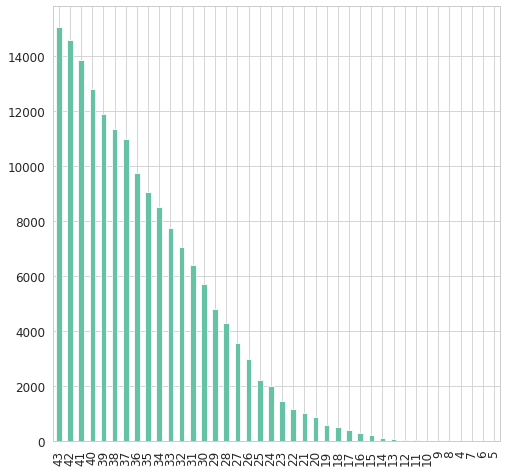

In [15]:
# find distribution of different atom numbers
atom25_df.atoms.value_counts().plot(kind='bar', figsize = (8,8))

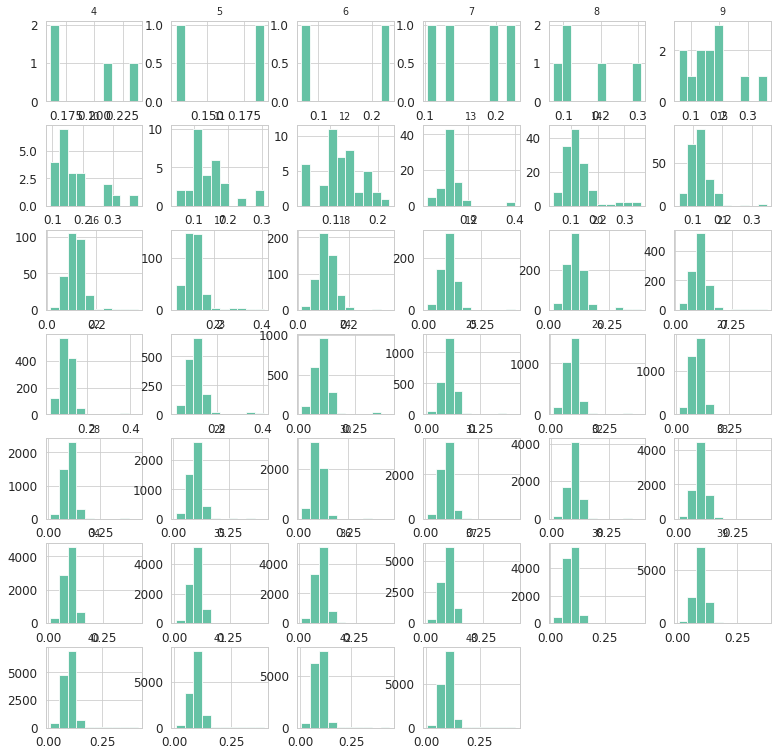

In [23]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
atom25_types = atom25_df.pivot_table(index = 'compound_id', columns = 'atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
atom25_types.hist(figsize=(13,13));

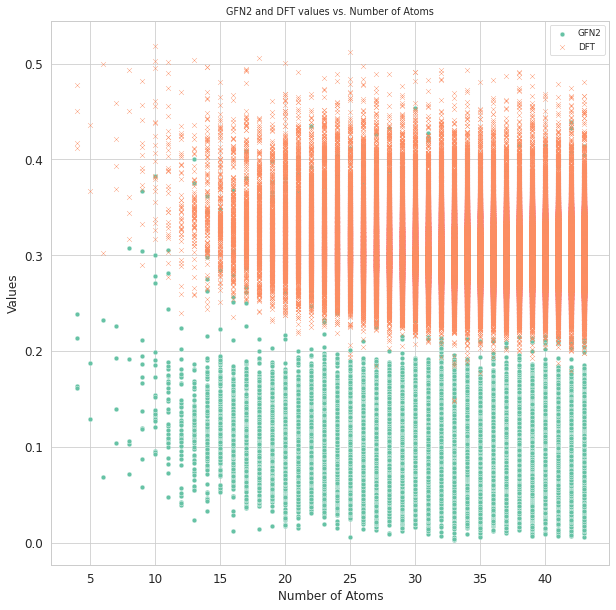

In [24]:
# scatter plots
sns.scatterplot(x = 'atoms', y='GFN2_HOMO_LUMO_GAP', data = atom25_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'atoms', y='DFT_HOMO_LUMO_GAP', data = atom25_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

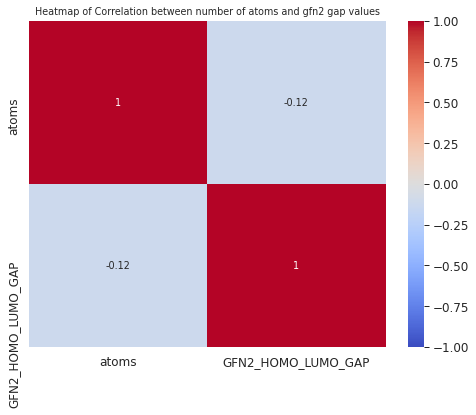

In [25]:
# Compute the correlation matrix
corr_matrix = atom25_df[['atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of atoms and gfn2 gap values')
plt.show()

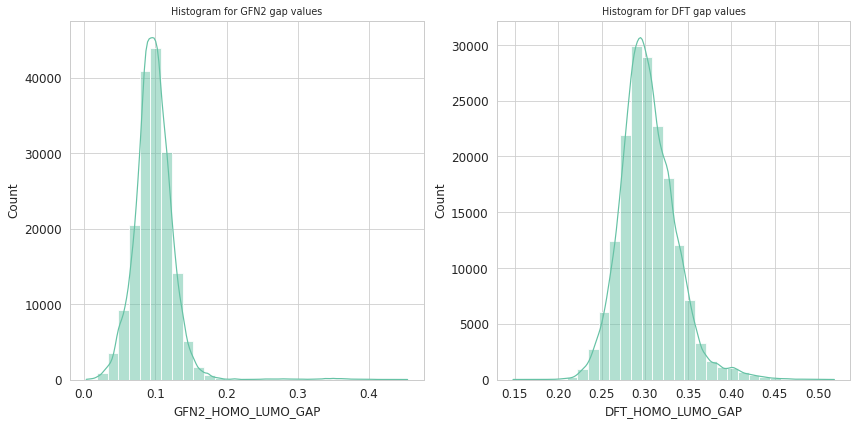

In [26]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(atom25_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(atom25_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### atoms, 50 percentile

<AxesSubplot:>

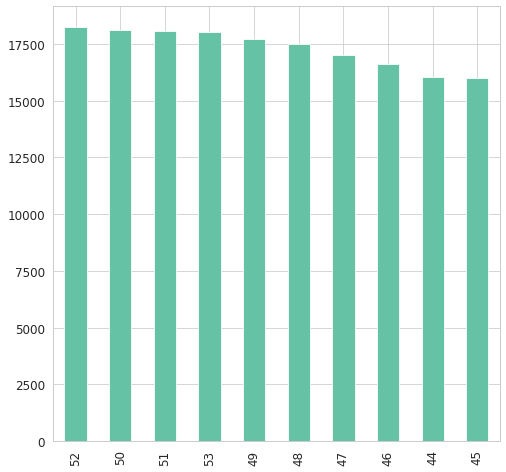

In [27]:
# find distribution of different atom numbers
atom50_df.atoms.value_counts().plot(kind='bar', figsize = (8,8))

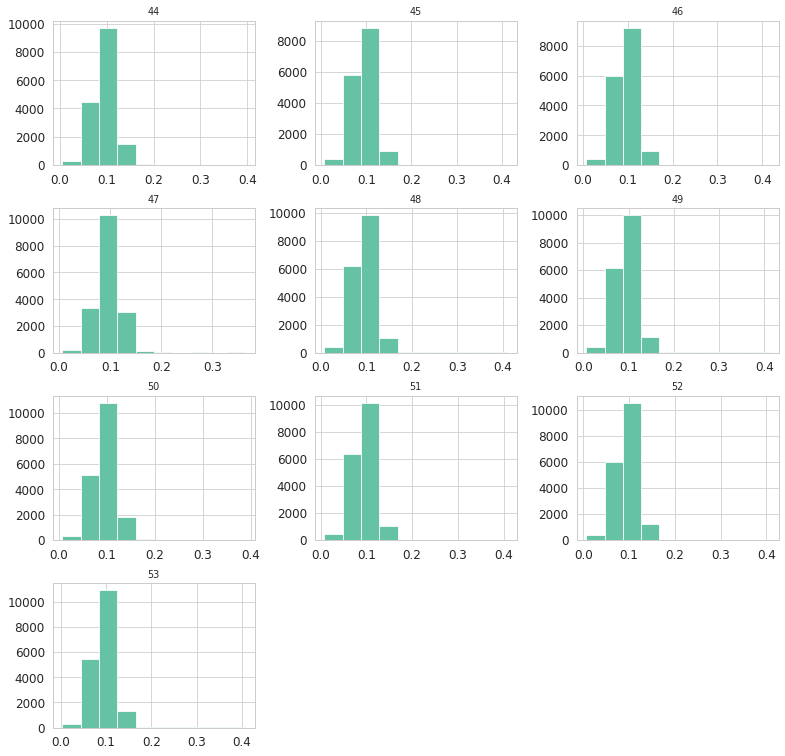

In [28]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
atom50_types = atom50_df.pivot_table(index = 'compound_id', columns = 'atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
atom50_types.hist(figsize=(13,13));

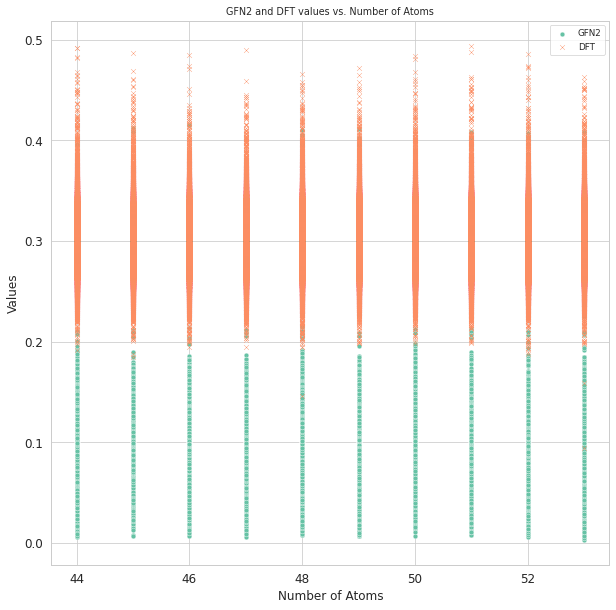

In [29]:
# scatter plots
sns.scatterplot(x = 'atoms', y='GFN2_HOMO_LUMO_GAP', data = atom50_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'atoms', y='DFT_HOMO_LUMO_GAP', data = atom50_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

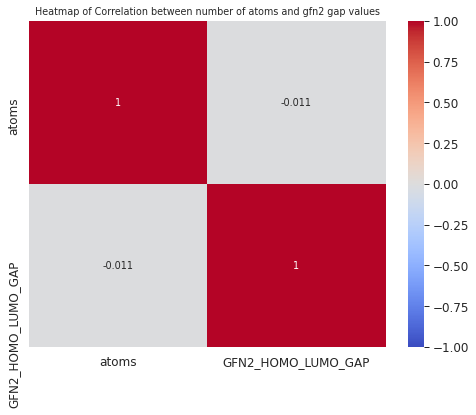

In [30]:
# Compute the correlation matrix
corr_matrix = atom50_df[['atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of atoms and gfn2 gap values')
plt.show()

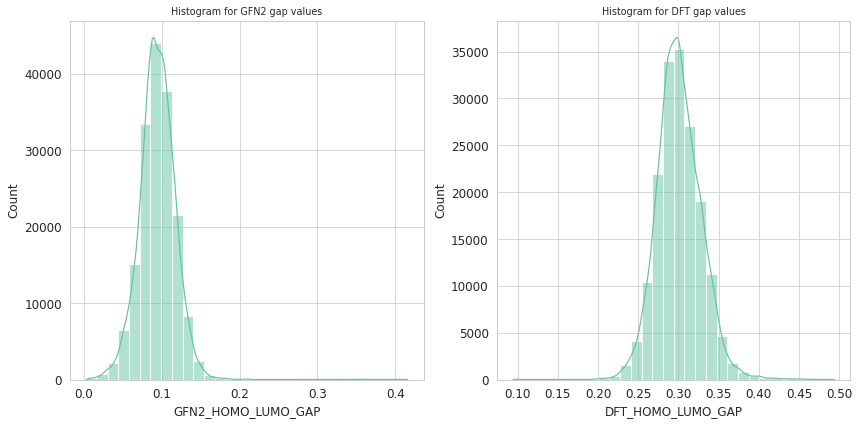

In [31]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(atom50_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(atom50_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### atoms, 75 percentile

<AxesSubplot:>

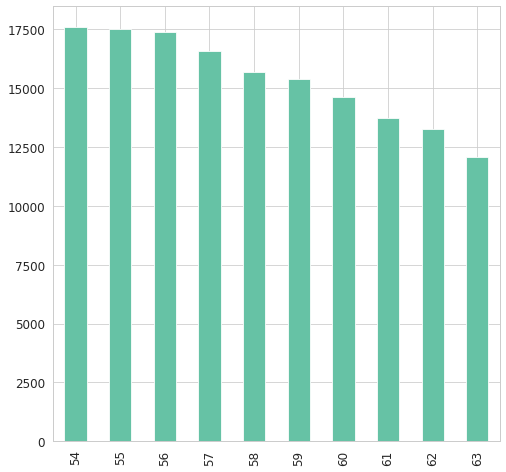

In [32]:
# find distribution of different atom numbers
atom75_df.atoms.value_counts().plot(kind='bar', figsize = (8,8))

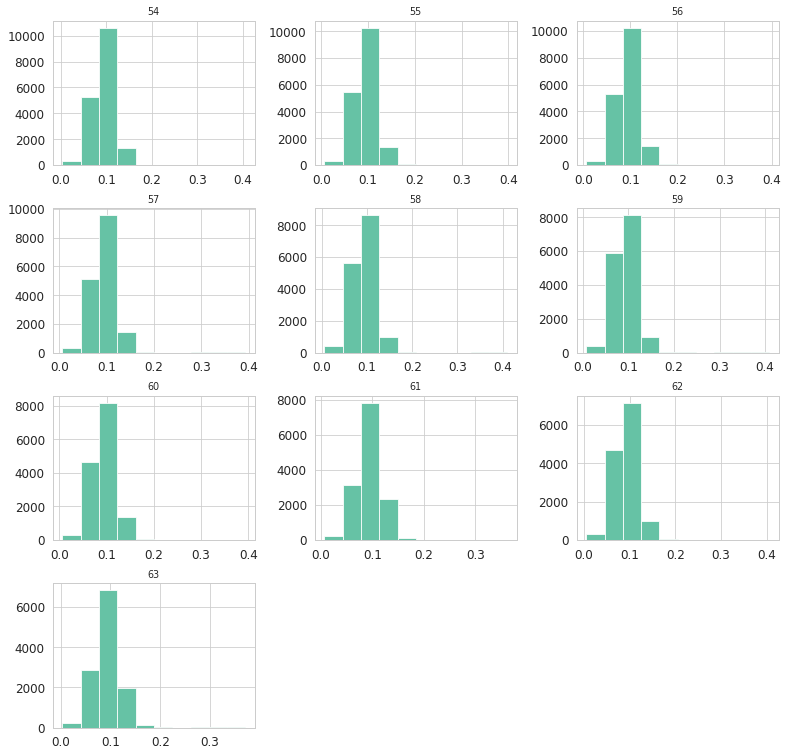

In [33]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
atom75_types = atom75_df.pivot_table(index = 'compound_id', columns = 'atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
atom75_types.hist(figsize=(13,13));

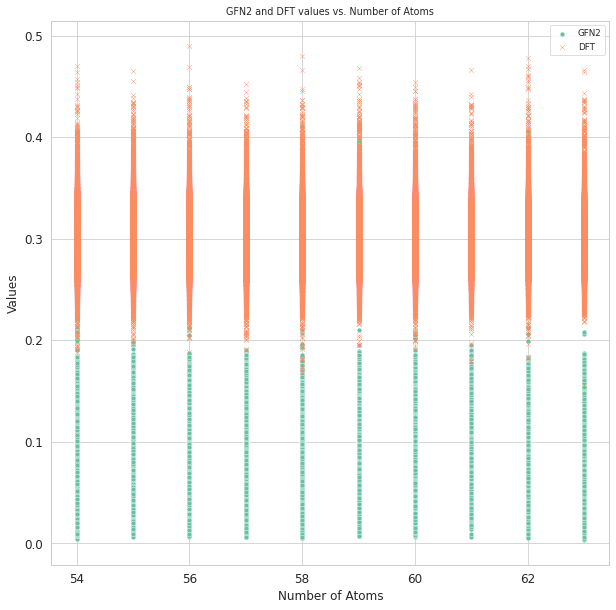

In [34]:
# scatter plots
sns.scatterplot(x = 'atoms', y='GFN2_HOMO_LUMO_GAP', data = atom75_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'atoms', y='DFT_HOMO_LUMO_GAP', data = atom75_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

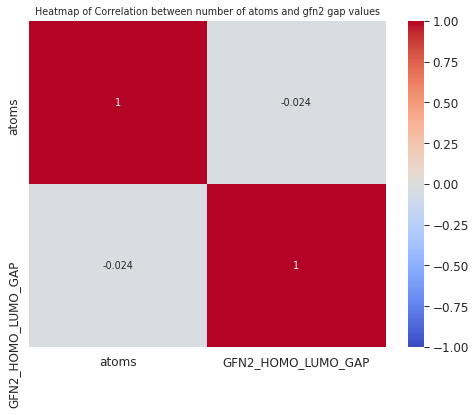

In [35]:
# Compute the correlation matrix
corr_matrix = atom75_df[['atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of atoms and gfn2 gap values')
plt.show()

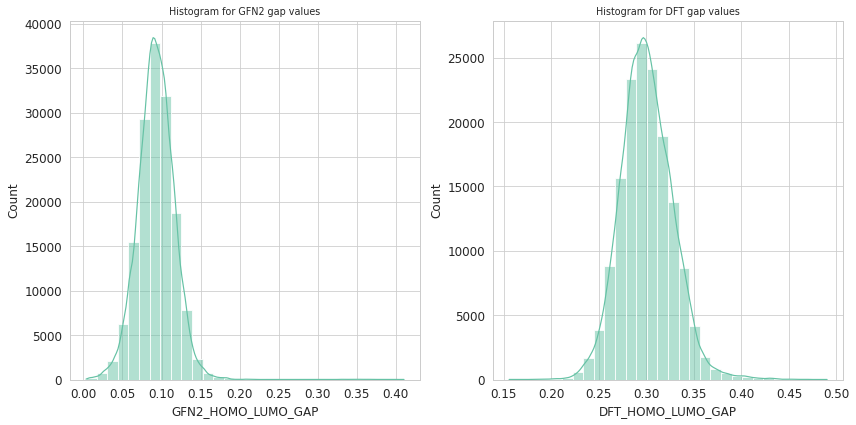

In [36]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(atom75_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(atom75_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### atoms, 100 percentile

<AxesSubplot:>

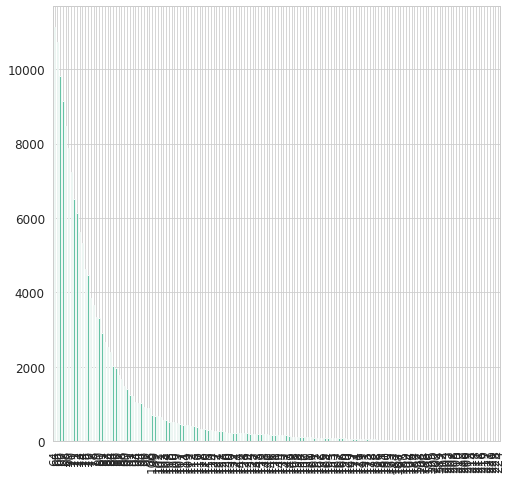

In [37]:
# find distribution of different atom numbers
atom100_df.atoms.value_counts().plot(kind='bar', figsize = (8,8))

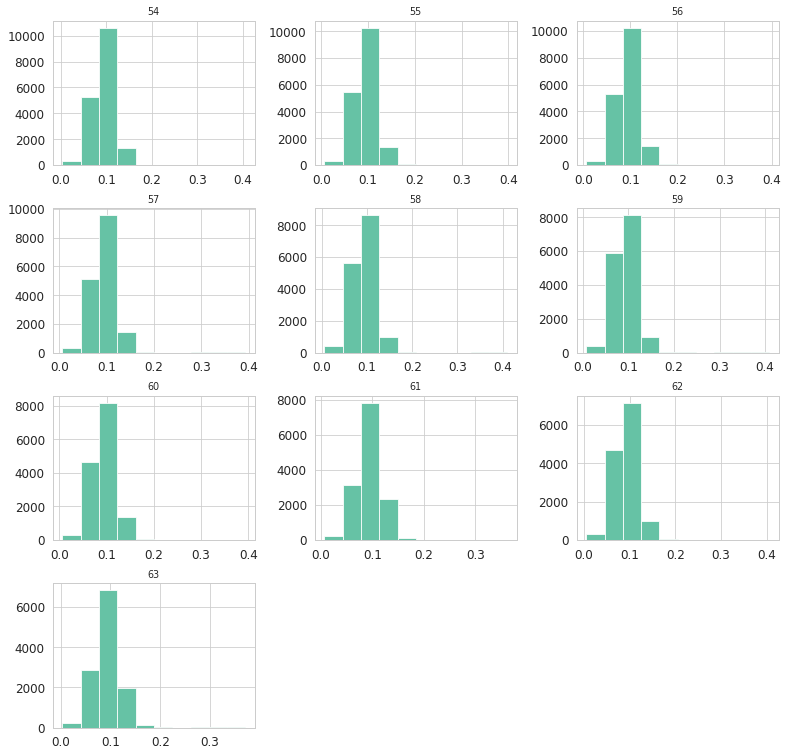

In [38]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
atom100_types = atom75_df.pivot_table(index = 'compound_id', columns = 'atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
atom100_types.hist(figsize=(13,13));

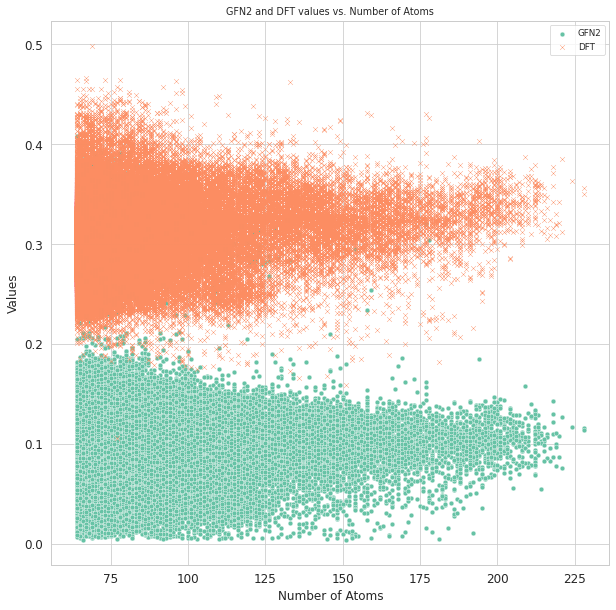

In [39]:
# scatter plots
sns.scatterplot(x = 'atoms', y='GFN2_HOMO_LUMO_GAP', data = atom100_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'atoms', y='DFT_HOMO_LUMO_GAP', data = atom100_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

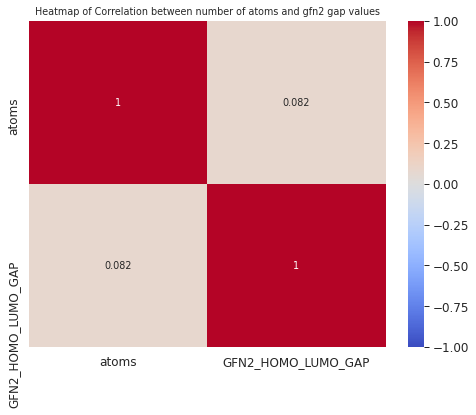

In [40]:
# Compute the correlation matrix
corr_matrix = atom100_df[['atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of atoms and gfn2 gap values')
plt.show()

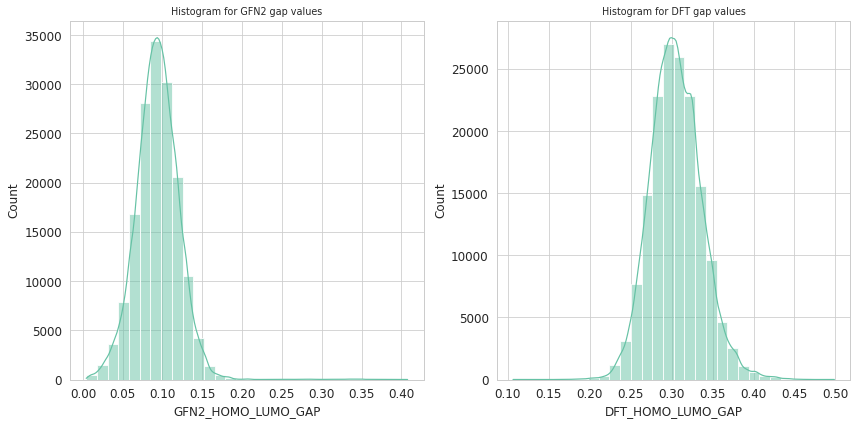

In [50]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(atom100_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(atom100_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### atoms, average

In [7]:
# plot each quantile together to see if there are shifts.

## Rings and gap values

#### rings

In [30]:
ring25_df = curated_df[curated_df["rings"] <= 3]
ring50_df = curated_df[(curated_df["rings"] > 3) & (curated_df["rings"] <= 4)]
ring75_df = curated_df[(curated_df["rings"] > 4) & (curated_df["rings"] <= 5)]
ring100_df = curated_df[curated_df["rings"] > 5 ]
ring_average_df = curated_df[curated_df["rings"] == 3.801509 ]

In [80]:
# check to see if filter works
ring25_df.head()

,chembl_id,conf_id,smiles,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,significant_negative_wavenumbers,nonunique_smiles,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,rdkit_smile,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
1,CHEMBL1000,conf_00,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,52,27,6,8,1,3,5,1,False,False,-80.315048,-68.493287,-11.821760,-79.870590,-79.950811,2.379,-3.195,4.509,6.017,5.337,-25.657,-4.502,-1.798,11.798,-0.835,0.009034,0.002935,0.002678,14005.394,888.752,1481.254,16375.401,91.382,2.981,4.968,99.331,88.721,36.373,43.746,168.840,-0.352364,-0.237194,0.115170,-0.294779,31094.695246,272.494292,-1609.322700,-1600.285930,-9.036771,2.142420,-2.785717,4.253252,5.517276,0.008840,0.002865,0.002636,-132.809395,2659.135307,-7485.087002,3349.488535,-0.296513,0.044311,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0
2,CHEMBL10000,conf_00,[H]c1c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H...,363.970876,28,19,5,2,0,3,4,1,False,False,-52.393036,-45.173987,-7.219049,-52.180530,-52.241437,-1.362,0.292,0.020,1.394,-14.034,-36.284,0.606,-4.581,-2.685,13.428,0.027951,0.002706,0.002467,8093.824,888.752,1481.254,10463.830,54.575,2.981,4.968,62.524,49.224,35.414,43.551,128.189,-0.392061,-0.285465,0.106596,-0.338763,15494.797760,200.975607,-1095.832353,-1090.450449,-5.381904,-0.349732,0.940967,0.138212,1.013328,0.027875,0.002163,0.002008,-91.786777,1456.814354,-4495.141648,2034.299009,-0.292609,0.000486,0.293095,O=c1oc(Nc2ccc(I)cc2)nc2ccccc12,KXLZEFPIBPQEAU-UHFFFAOYSA-N,0.289124,0.003439,1.373521,0
3,CHEMBL100003,conf_00,[H]O/C(OC([H])([H])[H])=C1\C(C([H])([H])[H])=N...,281.162708,43,20,5,11,1,1,5,1,False,False,-63.044635,-53.625801,-9.418834,-62.664873,-62.740190,-4.793,-0.892,0.956,4.970,29.019,4.478,-8.898,-11.014,-3.925,-20.121,0.017387,0.007241,0.006572,12871.935,888.752,1481.254,15241.942,78.134,2.981,4.968,86.083,81.802,33.934,42.782,158.518,-0.350243,-0.270147,0.080096,-0.310195,16751.288449,195.140373,-940.100277,-932.957960,-7.142316,-4.986451,-0.869709,2.092616,5.477238,0.017294,0.007228,0.006575,-90.337873,1704.654877,-4667.691840,2113.309805,-0.263692,0.011718,0.275410,CCC[C@@H]1C(C(=O)OCC)=C(C)N=C(C)/C1=C(\O)OC,FCFUFMMLEUYHMD-CDZMIXDFSA-N,0.282891,0.007237,2.644696,0
4,CHEMBL100004,conf_00,[H]O/C(OC([H])([H])C([H])([H])[H])=C1\C(C([H])...,375.150429,51,26,6,12,1,2,6,1,False,False,-78.009245,-66.525705,-11.483539,-77.573112,-77.659095,-6.628,0.168,2.814,7.203,13.223,-5.233,-9.217,-3.183,3.113,-4.005,0.012093,0.002612,0.002261,15834.103,888.752,1481.254,18204.109,97.510,2.981,4.968,105.459,100.957,36.367,43.642,180.966,-0.353439,-0.283588,0.069851,-0.318514,29419.012760,265.673033,-1529.710027,-1520.925372,-8.784655,-6.228561,1.164321,2.815141,6.933659,0.012092,0.002591,0.002246,-128.312742,2455.485098,-6971.678300,3114.833616,-0.274412,-0.002106,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...,

In [31]:
ring25_df = ring25_df[["chembl_id","compound_id","rings","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
ring50_df = ring50_df[["chembl_id","compound_id","rings","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
ring75_df = ring75_df[["chembl_id","compound_id","rings","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
ring100_df = ring100_df[["chembl_id","compound_id","rings","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
ring_average_df = ring_average_df[["chembl_id","compound_id","rings","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]

#### rings, 25 percentile

<AxesSubplot:>

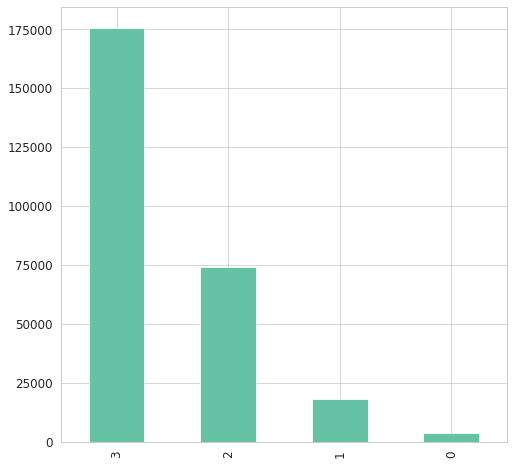

In [82]:
# find distribution of different ring numbers
ring25_df.rings.value_counts().plot(kind='bar', figsize = (8,8))

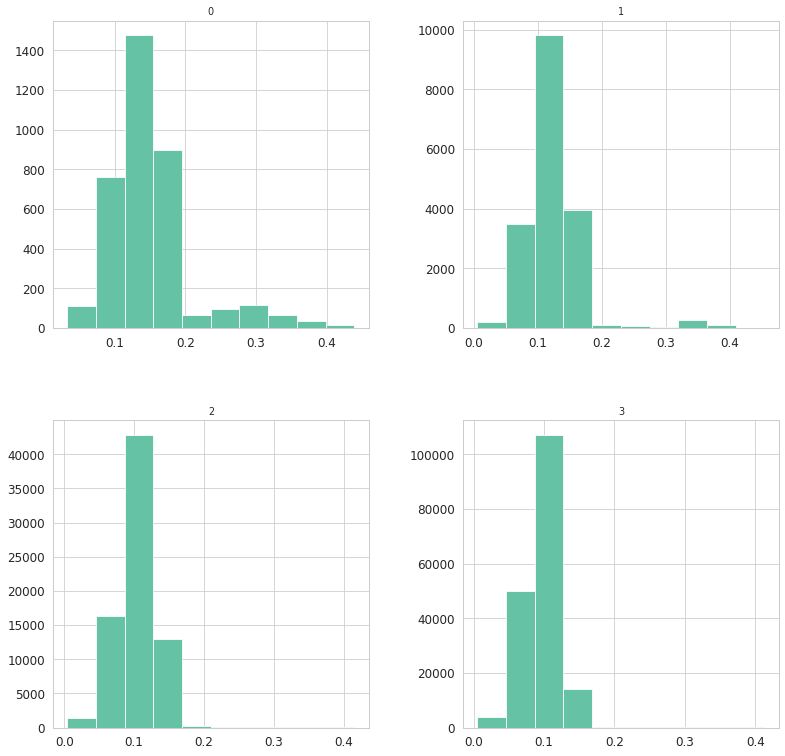

In [83]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
ring25_types = ring25_df.pivot_table(index = 'compound_id', columns = 'rings', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
ring25_types.hist(figsize=(13,13));

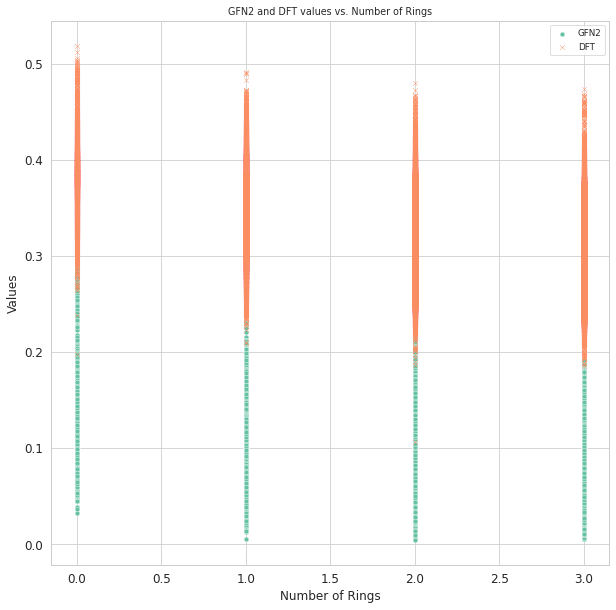

In [84]:
# scatter plots
sns.scatterplot(x = 'rings', y='GFN2_HOMO_LUMO_GAP', data = ring25_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'rings', y='DFT_HOMO_LUMO_GAP', data = ring25_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Rings')
plt.xlabel('Number of Rings')
plt.ylabel('Values')
plt.legend()
plt.show()

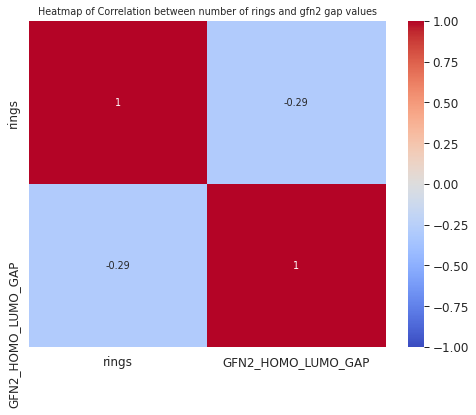

In [85]:
# Compute the correlation matrix
corr_matrix = ring25_df[['rings', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of rings and gfn2 gap values')
plt.show()

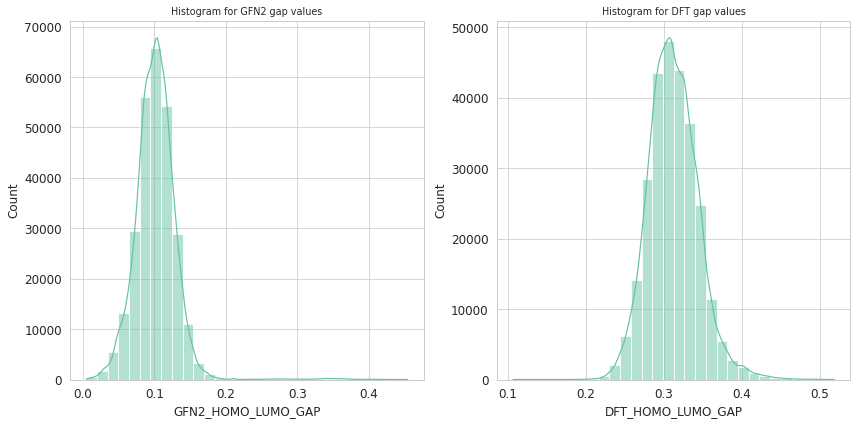

In [86]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ring25_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(ring25_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### rings, 50 percentile

<AxesSubplot:>

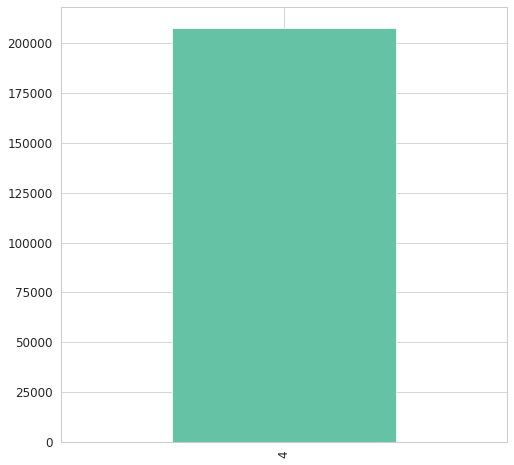

In [87]:
# find distribution of different ring numbers
ring50_df.rings.value_counts().plot(kind='bar', figsize = (8,8))

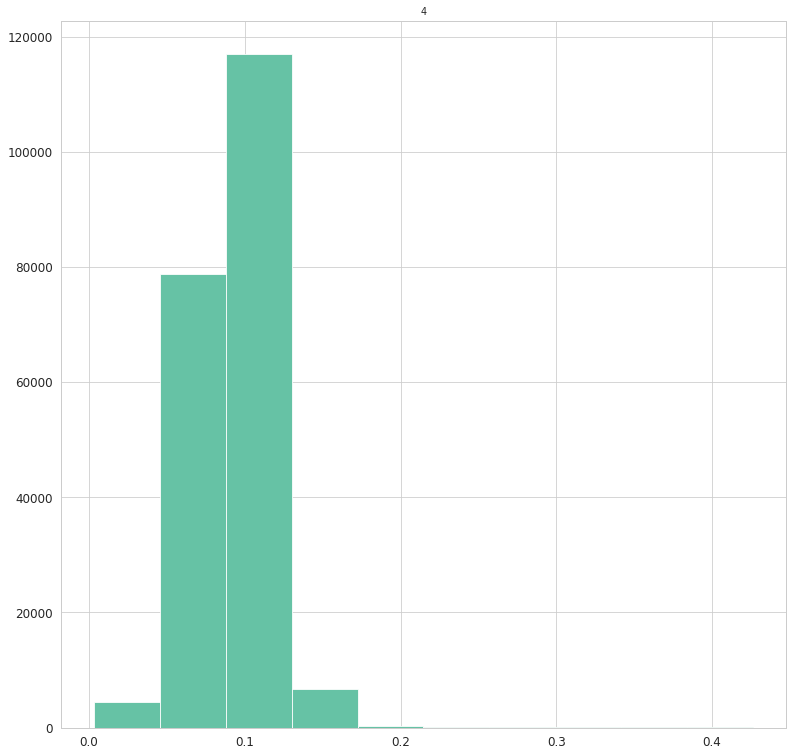

In [88]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
ring50_types = ring50_df.pivot_table(index = 'compound_id', columns = 'rings', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
ring50_types.hist(figsize=(13,13));

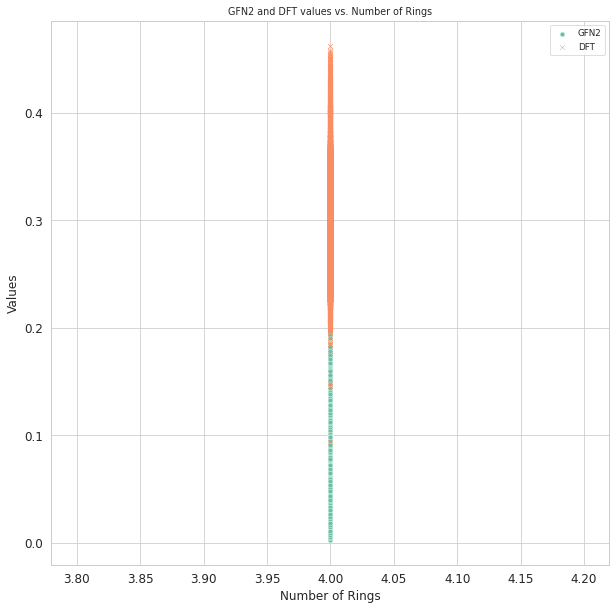

In [89]:
# scatter plots
sns.scatterplot(x = 'rings', y='GFN2_HOMO_LUMO_GAP', data = ring50_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'rings', y='DFT_HOMO_LUMO_GAP', data = ring50_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Rings')
plt.xlabel('Number of Rings')
plt.ylabel('Values')
plt.legend()
plt.show()

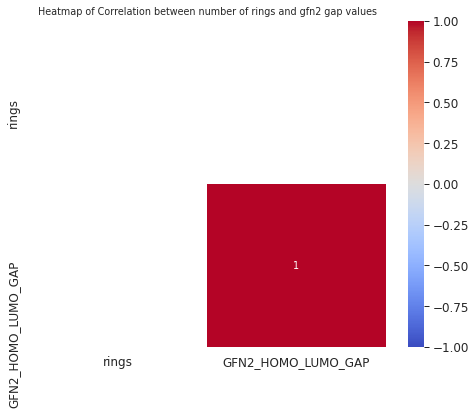

In [90]:
# Compute the correlation matrix
corr_matrix = ring50_df[['rings', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of rings and gfn2 gap values')
plt.show()

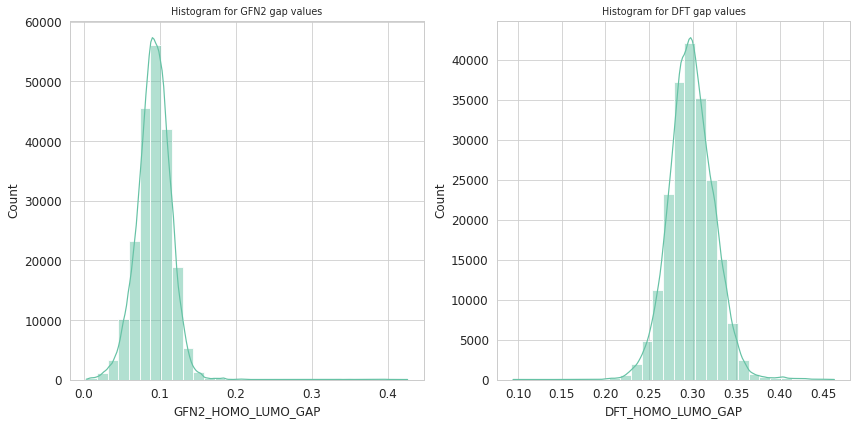

In [91]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ring50_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(ring50_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### rings, 75 percentile

<AxesSubplot:>

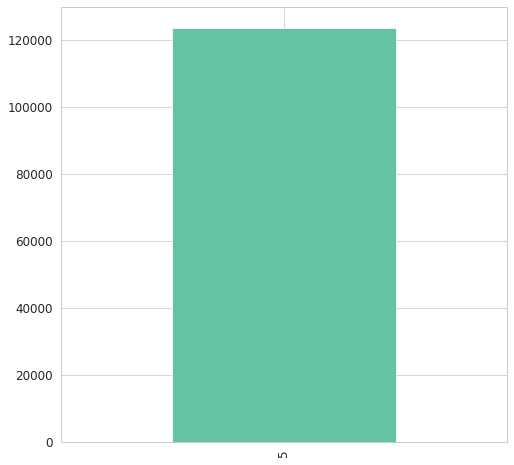

In [92]:
# find distribution of different ring numbers
ring75_df.rings.value_counts().plot(kind='bar', figsize = (8,8))

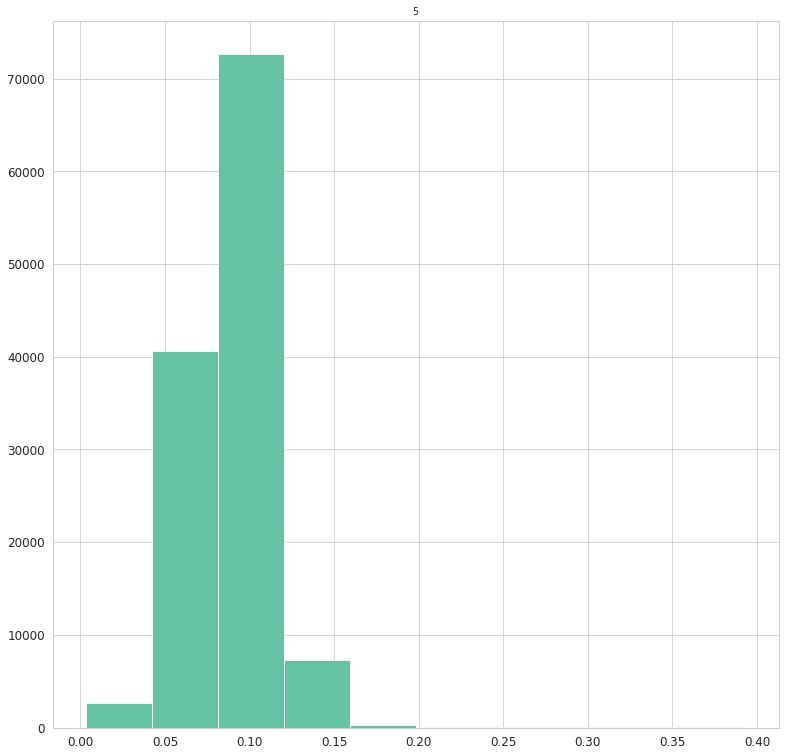

In [93]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
ring75_types = ring75_df.pivot_table(index = 'compound_id', columns = 'rings', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
ring75_types.hist(figsize=(13,13));

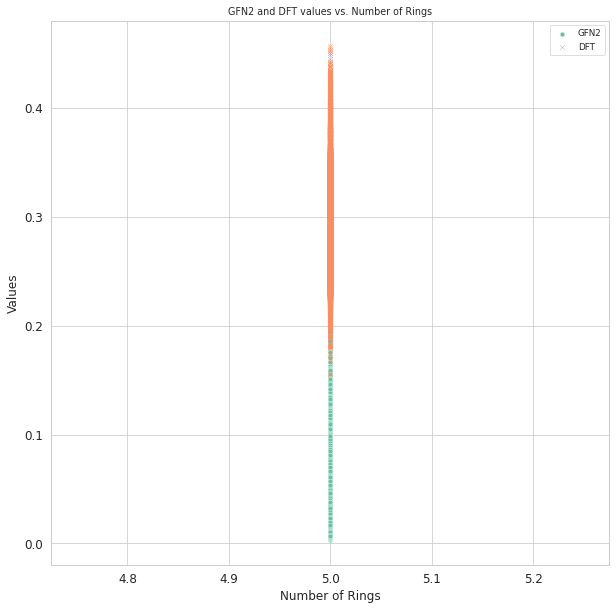

In [94]:
# scatter plots
sns.scatterplot(x = 'rings', y='GFN2_HOMO_LUMO_GAP', data = ring75_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'rings', y='DFT_HOMO_LUMO_GAP', data = ring75_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Rings')
plt.xlabel('Number of Rings')
plt.ylabel('Values')
plt.legend()
plt.show()

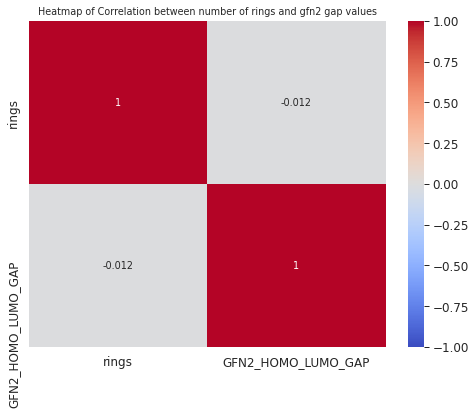

In [95]:
# Compute the correlation matrix
corr_matrix = ring100_df[['rings', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of rings and gfn2 gap values')
plt.show()

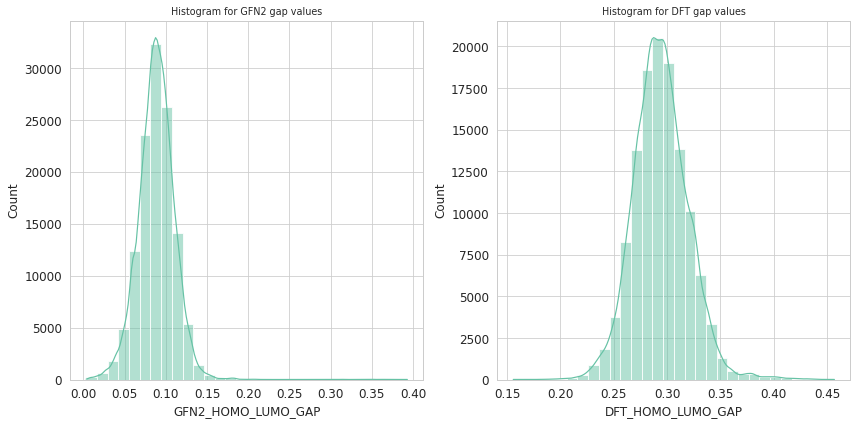

In [97]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ring75_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(ring75_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### rings, 100 percentile

<AxesSubplot:>

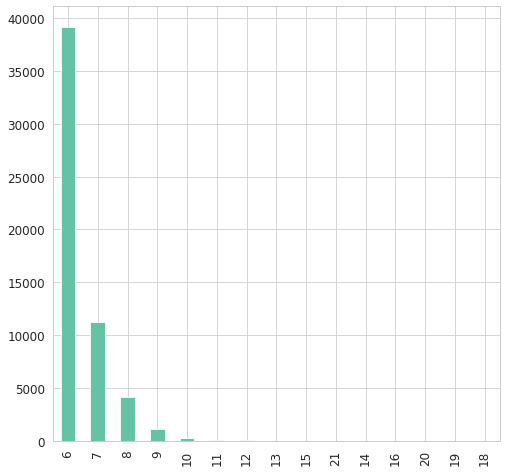

In [98]:
# find distribution of different ring numbers
ring100_df.rings.value_counts().plot(kind='bar', figsize = (8,8))

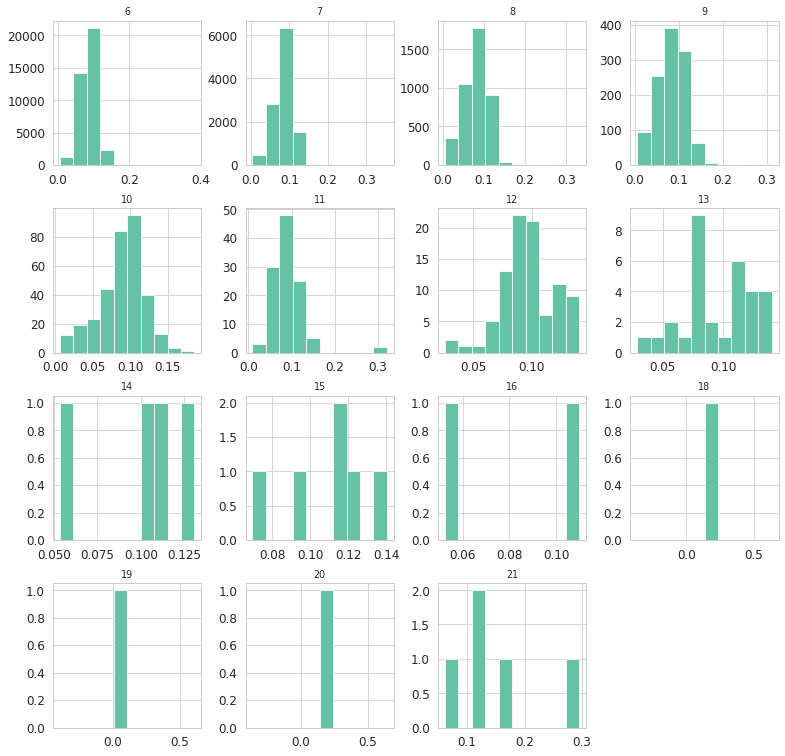

In [99]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
ring100_types = ring100_df.pivot_table(index = 'compound_id', columns = 'rings', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
ring100_types.hist(figsize=(13,13));

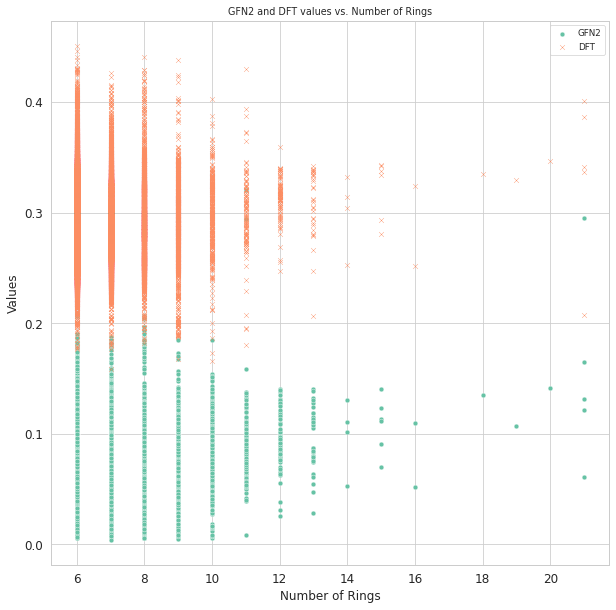

In [100]:
# scatter plots
sns.scatterplot(x = 'rings', y='GFN2_HOMO_LUMO_GAP', data = ring100_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'rings', y='DFT_HOMO_LUMO_GAP', data = ring100_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Rings')
plt.xlabel('Number of Rings')
plt.ylabel('Values')
plt.legend()
plt.show()

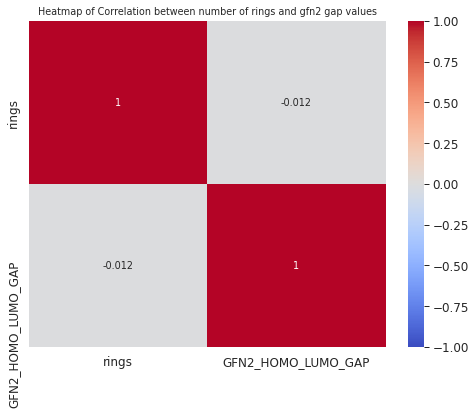

In [101]:
# Compute the correlation matrix
corr_matrix = ring100_df[['rings', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of rings and gfn2 gap values')
plt.show()

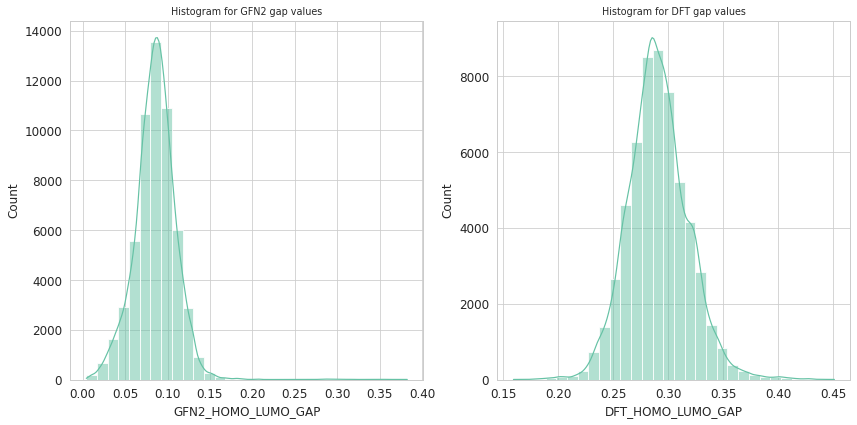

In [102]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ring100_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(ring100_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### rings, average

IndexError: index 0 is out of bounds for axis 0 with size 0

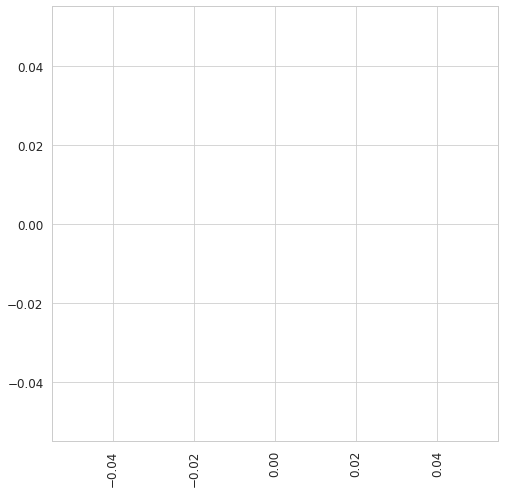

In [32]:
# find distribution of average rings
ring_average_df.rings.value_counts().plot(kind='bar', figsize = (8,8))

## Heavy atoms counts and gap values

#### heavy atoms

In [13]:
heavy_atom25_df = curated_df[curated_df["heavy_atoms"] <= 20]
heavy_atom50_df = curated_df[(curated_df["heavy_atoms"] > 20) & (curated_df["heavy_atoms"] <= 30)]
heavy_atom75_df = curated_df[(curated_df["heavy_atoms"] > 30) & (curated_df["heavy_atoms"] <= 35)]
heavy_atom100_df = curated_df[curated_df["heavy_atoms"] > 35 ]
heavy_atom_average_df = curated_df[curated_df["heavy_atoms"] == 30.626933 ]

In [14]:
# check to see if filter works
heavy_atom50_df.head()

,chembl_id,conf_id,smiles,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,significant_negative_wavenumbers,nonunique_smiles,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,rdkit_smile,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
1,CHEMBL1000,conf_00,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,52,27,6,8,1,3,5,1,False,False,-80.315048,-68.493287,-11.821760,-79.870590,-79.950811,2.379,-3.195,4.509,6.017,5.337,-25.657,-4.502,-1.798,11.798,-0.835,0.009034,0.002935,0.002678,14005.394,888.752,1481.254,16375.401,91.382,2.981,4.968,99.331,88.721,36.373,43.746,168.840,-0.352364,-0.237194,0.115170,-0.294779,31094.695246,272.494292,-1609.322700,-1600.285930,-9.036771,2.142420,-2.785717,4.253252,5.517276,0.008840,0.002865,0.002636,-132.809395,2659.135307,-7485.087002,3349.488535,-0.296513,0.044311,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0
4,CHEMBL100004,conf_00,[H]O/C(OC([H])([H])C([H])([H])[H])=C1\C(C([H])...,375.150429,51,26,6,12,1,2,6,1,False,False,-78.009245,-66.525705,-11.483539,-77.573112,-77.659095,-6.628,0.168,2.814,7.203,13.223,-5.233,-9.217,-3.183,3.113,-4.005,0.012093,0.002612,0.002261,15834.103,888.752,1481.254,18204.109,97.510,2.981,4.968,105.459,100.957,36.367,43.642,180.966,-0.353439,-0.283588,0.069851,-0.318514,29419.012760,265.673033,-1529.710027,-1520.925372,-8.784655,-6.228561,1.164321,2.815141,6.933659,0.012092,0.002591,0.002246,-128.312742,2455.485098,-6971.678300,3114.833616,-0.274412,-0.002106,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...,CUHAMGYOMBKPLA-BQOWYSNXSA-N,0.272592,0.003115,0.104604,0
5,CHEMBL100005,conf_02,[H]c1c([H])c(C([H])([H])[C@]([H])(C(=O)OC([H])...,385.131408,48,29,5,5,1,5,5,0,False,False,-80.294618,-68.191537,-12.103081,-79.903792,-79.981805,2.318,-2.097,1.395,3.422,-11.183,11.157,14.122,3.898,-3.877,-2.939,0.008664,0.004723,0.003824,13518.505,888.752,1481.254,15888.511,89.200,2.981,4.968,97.149,84.884,35.588,43.720,164.191,-0.361360,-0.293061,0.068298,-0.327211,30460.483535,274.751815,-1280.302706,-1271.130885,-9.171821,2.232262,-1.689740,1.644240,3.246805,0.008647,0.004717,0.003817,-123.306232,2770.708763,-7250.024688,3322.364334,-0.276278,-0.019839,0.256438,COC(=O)[C@@H](Cc1ccc2c(c1)OCO2)c1c2ccccc2nc2cc...,KXSQTEDQWJHEDB-SFHVURJKSA-N,0.256484,0.002403,0.017652,0
9,CHEMBL100020,conf_00,[H]c1c([H])c([H])c(C(=O)N([H])C(=S)N([H])C([H]...,381.187483,54,27,5,6,0,3,3,2,False,False,-76.992961,-64.808091,-12.184870,-76.521272,-76.603247,2.780,-1.606,2.897,4.325,29.157,-1.367,-8.433,14.356,11.052,-20.723,0.012666,0.001637,0.001545,14311.707,888.752,1481.254,16681.713,92.662,2.981,4.968,100.611,91.679,37.164,43.690,172.532,-0.347090,-0.288399,0.058691,-0.317601,33802.572084,287.917301,-1491.069698,-1481.641351,-9.428347,2.791788,-1.150492,2.493658,3.916126,0.012544,0.001617,0.001527,-127.799267,2382.284705,-6765.768603,3020.256388,-0.289296,-0.000877,0.288420,O=C(NC(=S)NCCC1CCN

In [15]:
heavy_atom25_df = heavy_atom25_df[["chembl_id","compound_id","heavy_atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
heavy_atom50_df = heavy_atom50_df[["chembl_id","compound_id","heavy_atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
heavy_atom75_df = heavy_atom75_df[["chembl_id","compound_id","heavy_atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
heavy_atom100_df = heavy_atom100_df[["chembl_id","compound_id","heavy_atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]
heavy_atom_average_df = heavy_atom_average_df[["chembl_id","compound_id","heavy_atoms","GFN2_HOMO_LUMO_GAP","DFT_HOMO_LUMO_GAP","rdkit_smile"]]

In [16]:
heavy_atom50_df.head()

,chembl_id,compound_id,heavy_atoms,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,rdkit_smile
1,CHEMBL1000,ZKLPARSLTMPFCP-NRFANRHFSA-N,27,0.115170,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1
4,CHEMBL100004,CUHAMGYOMBKPLA-BQOWYSNXSA-N,26,0.069851,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...
5,CHEMBL100005,KXSQTEDQWJHEDB-SFHVURJKSA-N,29,0.068298,0.256438,COC(=O)[C@@H](Cc1ccc2c(c1)OCO2)c1c2ccccc2nc2cc...
9,CHEMBL100020,VZGIPERPUUMOQR-UHFFFAOYSA-N,27,0.058691,0.288420,O=C(NC(=S)NCCC1CCN(Cc2ccccc2)CC1)c1ccccc1
10,CHEMBL100029,GFRHLCDSWKISNK-UHFFFAOYSA-N,24,0.108617,0.297044,O=C(Cc1c(-c2ccccc2)[nH]c2ccccc12)N1CCCCC1


#### heavy atoms, 25 percentile

<AxesSubplot:>

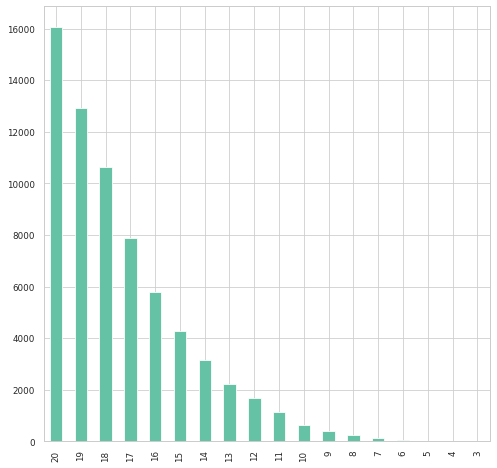

In [17]:
# find distribution of different heavy atom numbers
heavy_atom25_df.heavy_atoms.value_counts().plot(kind='bar', figsize = (8,8))

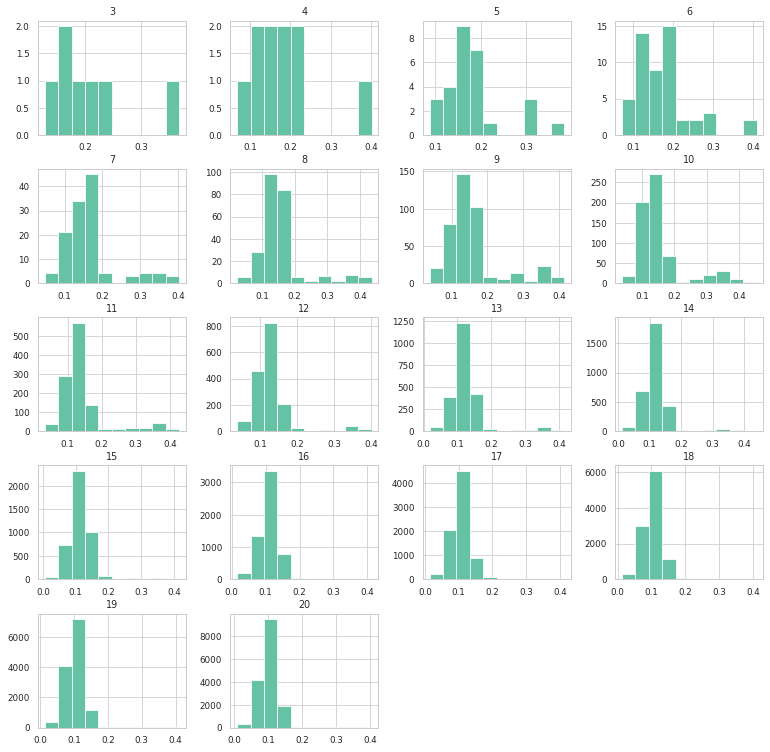

In [18]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
heavy_atom25_types = heavy_atom25_df.pivot_table(index = 'compound_id', columns = 'heavy_atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
heavy_atom25_types.hist(figsize=(13,13));

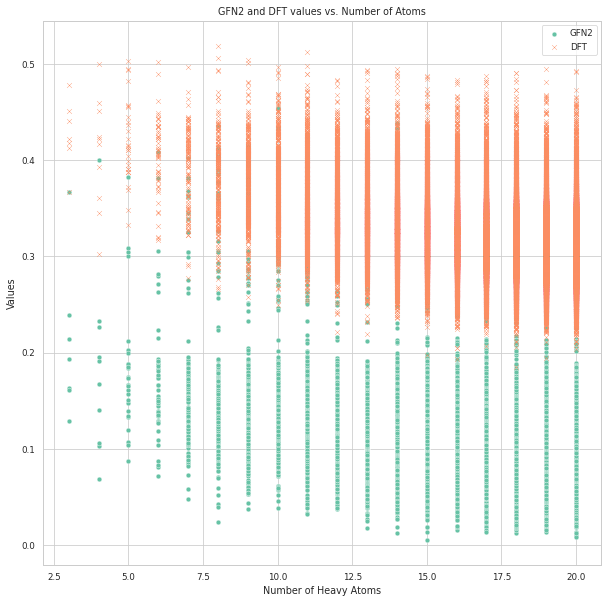

In [19]:
# scatter plots
sns.scatterplot(x = 'heavy_atoms', y='GFN2_HOMO_LUMO_GAP', data = heavy_atom25_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'heavy_atoms', y='DFT_HOMO_LUMO_GAP', data = heavy_atom25_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

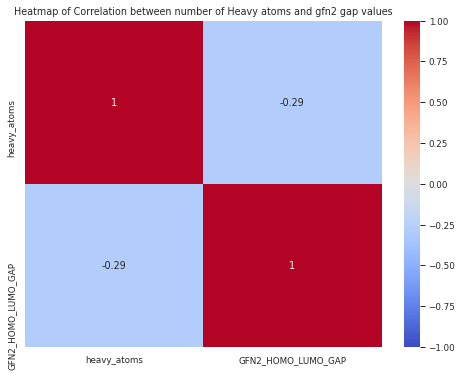

In [20]:
# Compute the correlation matrix
corr_matrix = heavy_atom25_df[['heavy_atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of Heavy atoms and gfn2 gap values')
plt.show()

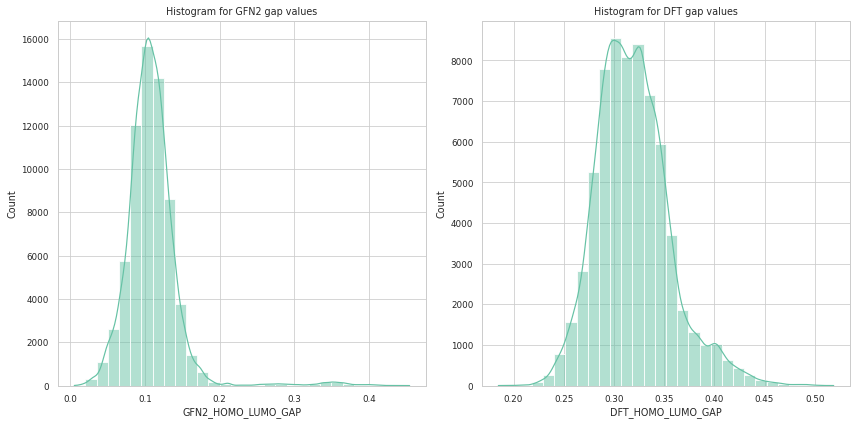

In [21]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(heavy_atom25_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(heavy_atom25_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### heavy atoms, 50 percentile

<AxesSubplot:>

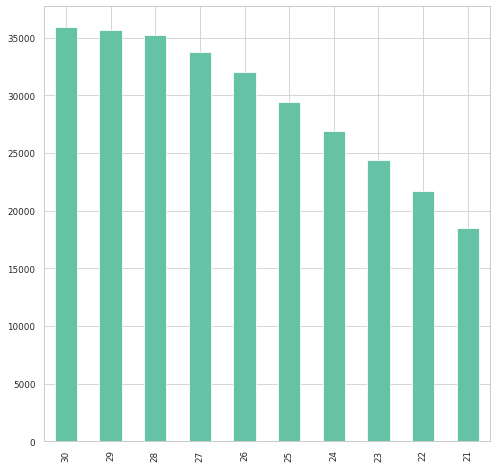

In [22]:
# find distribution of different heavy atom numbers
heavy_atom50_df.heavy_atoms.value_counts().plot(kind='bar', figsize = (8,8))

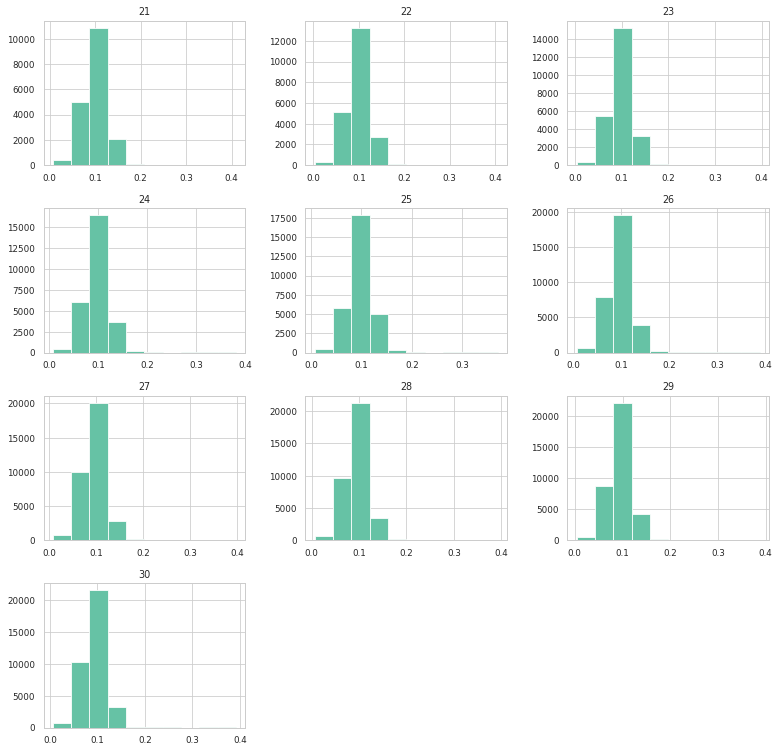

In [23]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
heavy_atom50_types = heavy_atom50_df.pivot_table(index = 'compound_id', columns = 'heavy_atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
heavy_atom50_types.hist(figsize=(13,13));

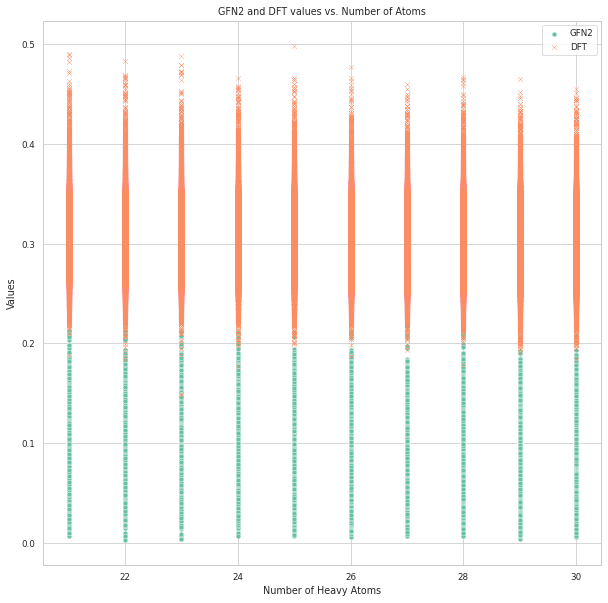

In [24]:
# scatter plots
sns.scatterplot(x = 'heavy_atoms', y='GFN2_HOMO_LUMO_GAP', data = heavy_atom50_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'heavy_atoms', y='DFT_HOMO_LUMO_GAP', data = heavy_atom50_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

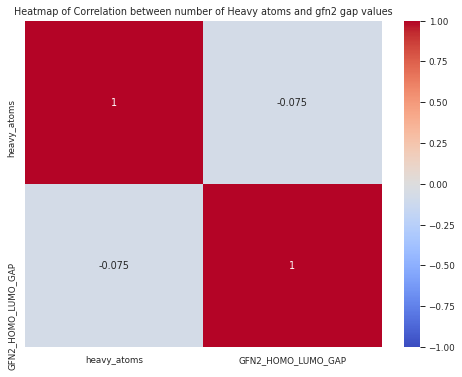

In [25]:
# Compute the correlation matrix
corr_matrix = heavy_atom50_df[['heavy_atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of Heavy atoms and gfn2 gap values')
plt.show()

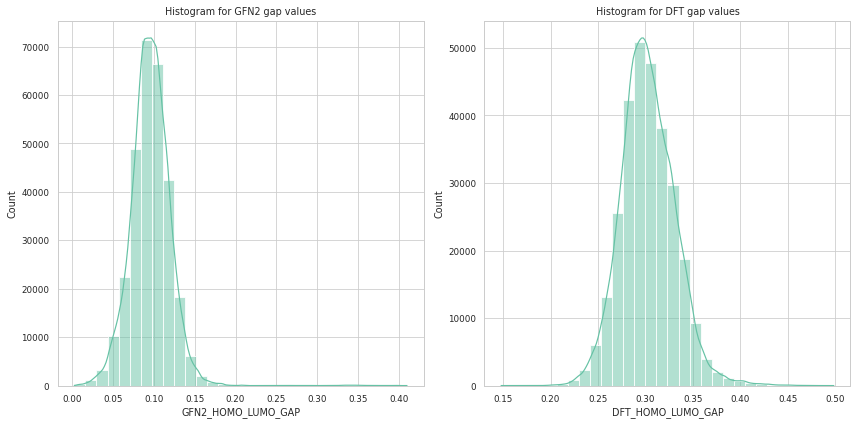

In [26]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(heavy_atom50_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(heavy_atom50_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### heavy atoms, 75 percentile

<AxesSubplot:>

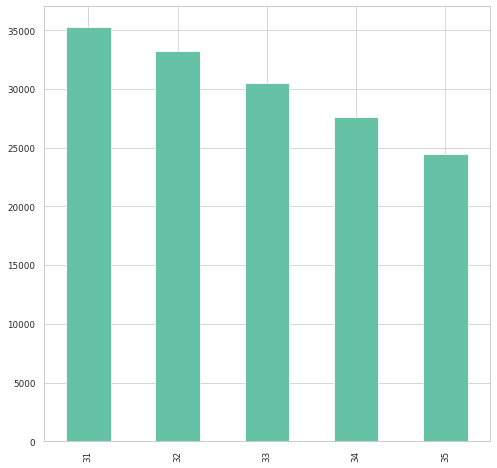

In [27]:
# find distribution of different heavy atom numbers
heavy_atom75_df.heavy_atoms.value_counts().plot(kind='bar', figsize = (8,8))

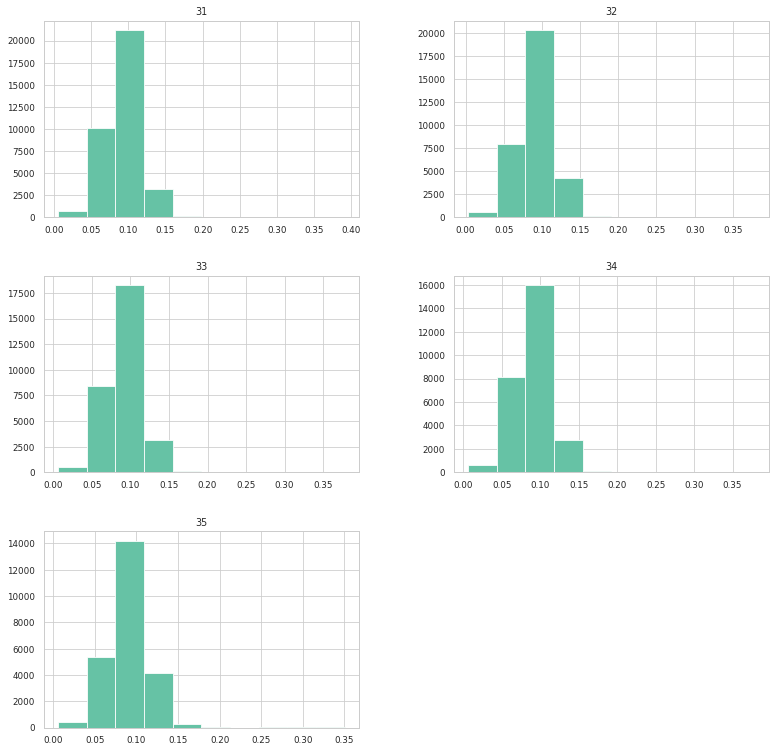

In [28]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
heavy_atom75_types = heavy_atom75_df.pivot_table(index = 'compound_id', columns = 'heavy_atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
heavy_atom75_types.hist(figsize=(13,13));

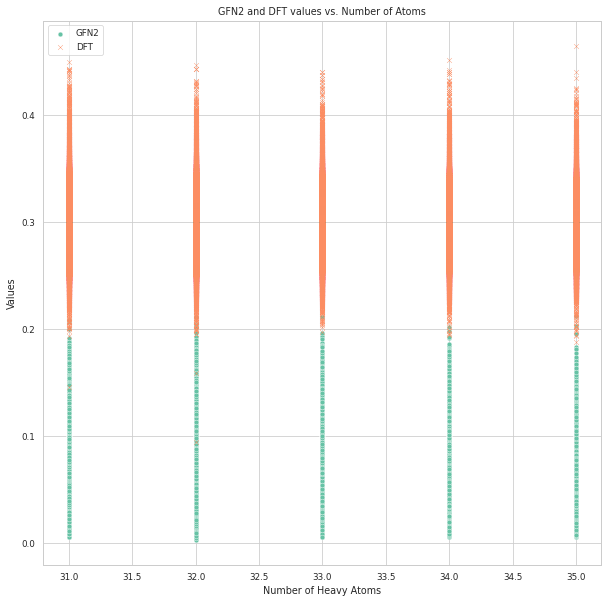

In [29]:
# scatter plots
sns.scatterplot(x = 'heavy_atoms', y='GFN2_HOMO_LUMO_GAP', data = heavy_atom75_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'heavy_atoms', y='DFT_HOMO_LUMO_GAP', data = heavy_atom75_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

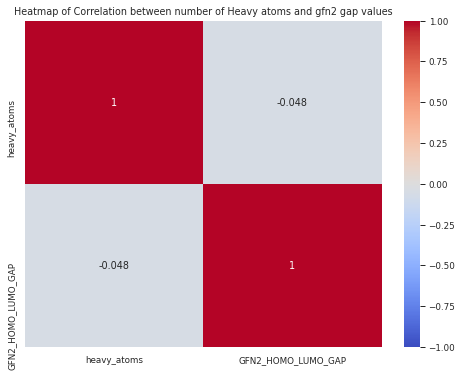

In [30]:
# Compute the correlation matrix
corr_matrix = heavy_atom75_df[['heavy_atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of Heavy atoms and gfn2 gap values')
plt.show()

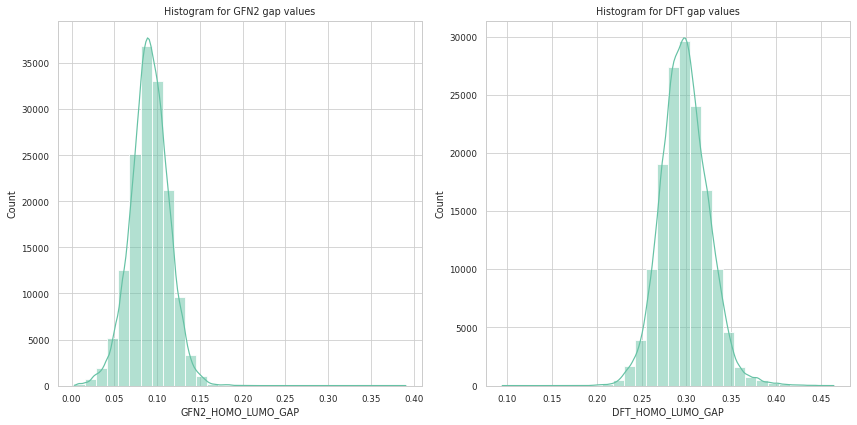

In [31]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(heavy_atom75_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(heavy_atom75_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### heavy atoms, 100 percentile

<AxesSubplot:>

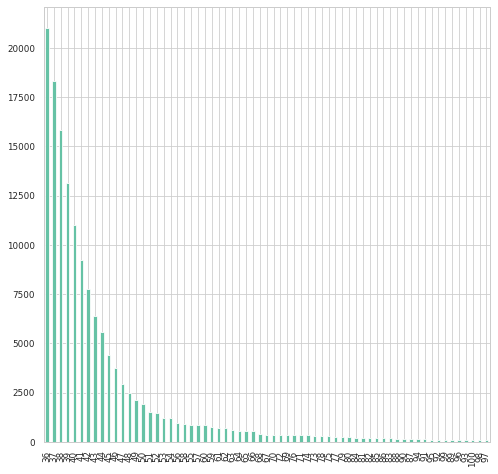

In [33]:
# find distribution of different heavy atom numbers
heavy_atom100_df.heavy_atoms.value_counts().plot(kind='bar', figsize = (8,8))

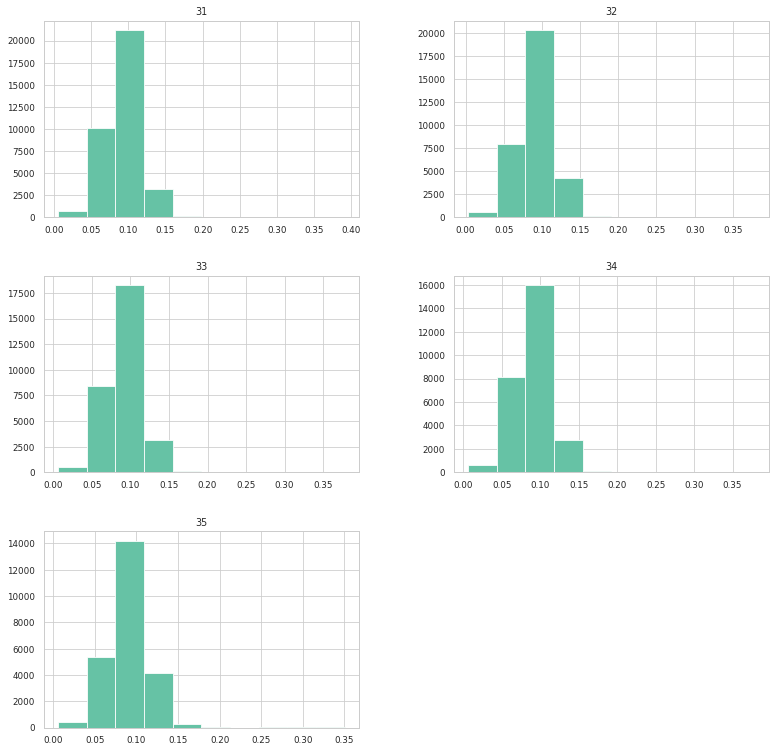

In [34]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
heavy_atom100_types = heavy_atom75_df.pivot_table(index = 'compound_id', columns = 'heavy_atoms', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
heavy_atom100_types.hist(figsize=(13,13));

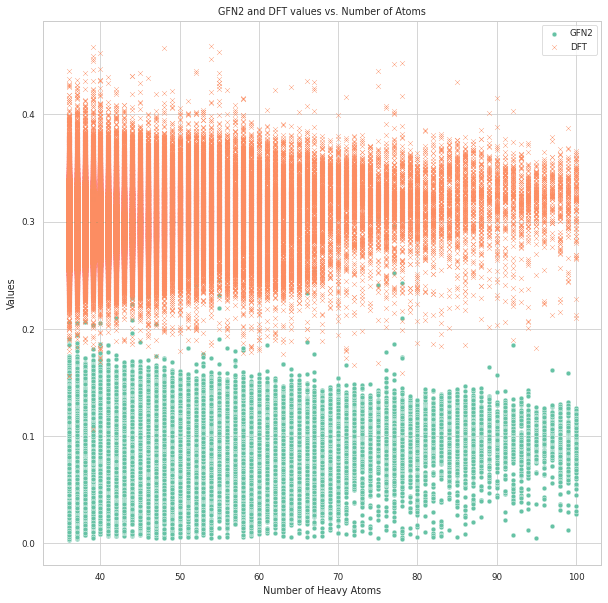

In [35]:
# scatter plots
sns.scatterplot(x = 'heavy_atoms', y='GFN2_HOMO_LUMO_GAP', data = heavy_atom100_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'heavy_atoms', y='DFT_HOMO_LUMO_GAP', data = heavy_atom100_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Values')
plt.legend()
plt.show()

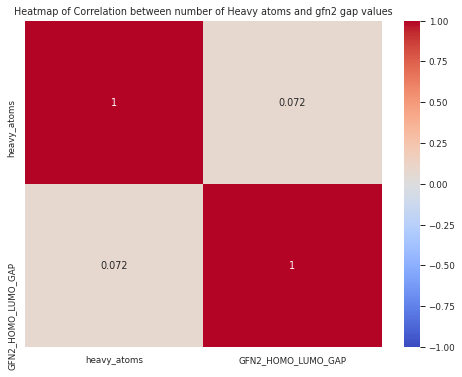

In [36]:
# Compute the correlation matrix
corr_matrix = heavy_atom100_df[['heavy_atoms', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of Heavy atoms and gfn2 gap values')
plt.show()

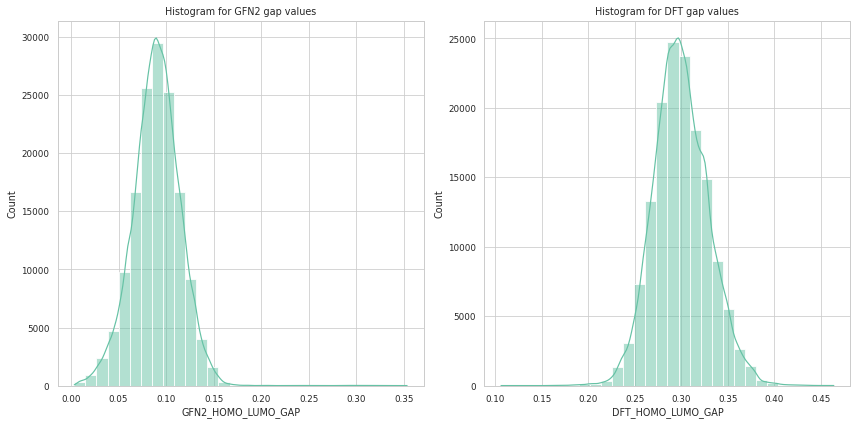

In [37]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(heavy_atom100_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(heavy_atom100_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()

#### heavy atoms, average

IndexError: index 0 is out of bounds for axis 0 with size 0

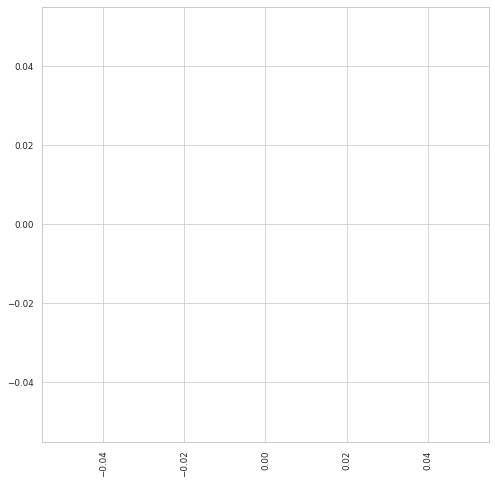

In [38]:
# find distribution of average heavy atom numbers
heavy_atom_average_df.heavy_atoms.value_counts().plot(kind='bar', figsize = (8,8))

## Molecular Weight and gap values

#### mw

In [13]:
mw25_df = curated_df[curated_df["mw"] <= 349.226646]
mw50_df = curated_df[(curated_df["mw"] > 349.226646) & (curated_df["mw"] <= 418.140783)]
mw75_df = curated_df[(curated_df["mw"] > 418.140783) & (curated_df["mw"] <= 491.118478)]
mw100_df = curated_df[curated_df["mw"] > 491.118478 ]
mw_average_df = curated_df[curated_df["mw"] == 432.990678 ]

In [14]:
# check to see if filter works
mw25_df.head()

,chembl_id,conf_id,smiles,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,significant_negative_wavenumbers,nonunique_smiles,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,rdkit_smile,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
3,CHEMBL100003,conf_00,[H]O/C(OC([H])([H])[H])=C1\C(C([H])([H])[H])=N...,281.162708,43,20,5,11,1,1,5,1,False,False,-63.044635,-53.625801,-9.418834,-62.664873,-62.740190,-4.793,-0.892,0.956,4.970,29.019,4.478,-8.898,-11.014,-3.925,-20.121,0.017387,0.007241,0.006572,12871.935,888.752,1481.254,15241.942,78.134,2.981,4.968,86.083,81.802,33.934,42.782,158.518,-0.350243,-0.270147,0.080096,-0.310195,16751.288449,195.140373,-940.100277,-932.957960,-7.142316,-4.986451,-0.869709,2.092616,5.477238,0.017294,0.007228,0.006575,-90.337873,1704.654877,-4667.691840,2113.309805,-0.263692,0.011718,0.275410,CCC[C@@H]1C(C(=O)OCC)=C(C)N=C(C)/C1=C(\O)OC,FCFUFMMLEUYHMD-CDZMIXDFSA-N,0.282891,0.007237,2.644696,0
6,CHEMBL100010,conf_01,[H]c1c([H])c([H])c(C2=C(C(=O)OC([H])([H])[H])[...,242.130680,36,18,2,3,2,3,2,0,False,False,-51.591222,-43.310646,-8.280577,-51.275771,-51.336977,-1.431,-1.052,1.317,2.212,0.485,-4.154,3.922,3.976,1.385,-4.407,0.019705,0.012370,0.008719,8477.505,888.752,1481.254,10847.511,56.574,2.981,4.968,64.523,53.486,32.996,42.337,128.820,-0.382563,-0.257754,0.124809,-0.320158,13562.233738,179.607696,-770.202248,-763.767820,-6.434427,-1.417204,-0.444106,0.700524,1.642081,0.019608,0.012267,0.008648,-76.098435,1340.771960,-3707.556233,1672.709355,-0.306396,0.030075,0.336471,COC(=O)C1=C(c2ccccc2)C[C@@H]2CC[C@H]1C2,BXNXEXWOZMNHST-YPMHNXCESA-N,0.337342,0.002364,0.258233,0
10,CHEMBL100029,conf_02,[H]c1c([H])c([H])c(-c2c(C([H])([H])C(=O)N3C([H...,318.173213,46,24,3,3,0,4,1,1,False,False,-66.142124,-55.295100,-10.847024,-65.742347,-65.813407,2.137,-2.821,-1.215,3.742,18.637,5.919,-11.163,-4.685,1.082,-7.475,0.009194,0.005835,0.003898,11346.835,888.752,1481.254,13716.841,76.677,2.981,4.968,84.626,71.108,35.300,43.151,149.559,-0.348921,-0.240304,0.108617,-0.294612,24255.083159,244.256587,-997.220303,-988.836443,-8.383860,1.440278,-2.397156,-1.614596,3.229191,0.009157,0.005705,0.003836,-99.386588,1968.251156,-5261.850209,2395.802299,-0.264223,0.032821,0.297044,O=C(Cc1c(-c2ccccc2)[nH]c2ccccc12)N1CCCCC1,GFRHLCDSWKISNK-UHFFFAOYSA-N,0.297546,0.002025,0.168715,0
12,CHEMBL100031,conf_00,[H]c1c([H])c([H])c(N2C([H])([H])C([H])([H])N(C...,337.176342,44,25,9,5,0,4,9,2,False,False,-70.265618,-59.621332,-10.644286,-69.897455,-69.970578,4.427,-4.023,-1.482,6.163,18.075,-6.293,-8.942,12.813,-2.736,-9.133,0.015622,0.003642,0.003377,12160.832,888.752,1481.254,14530.838,80.714,2.981,4.968,88.663,75.192,35.384,43.323,153.899,-0.328885,-0.307294,0.021591,-0.318089,23583.788924,237.988269,-1112.723021,-1105.018704,-7.704317,4.338877,-3.856202,-1.117755,5.911474,0.015356,0.003569,0.003302,-107.746079,2153.643180,-5789.620521,2631.036540,-0.253953,-0.026702,0.227251,Nc1nc(N)c2nc(CN3CCN(c4ccccc4)CC3)nnc2n1,YUVQKQXYTR

#### mw, 25 percentile

In [ ]:
# find distribution of different molecular weights
mw25_df.mw.value_counts().plot(kind='bar', figsize = (8,8))

<AxesSubplot:>

In [ ]:
# examine GFN2 HOMO LUMO GAP Value PER Compound Id
mw25_types = mw25_df.pivot_table(index = 'compound_id', columns = 'mw', values='GFN2_HOMO_LUMO_GAP', aggfunc='mean')
mw25_types.hist(figsize=(13,13));

In [ ]:
# scatter plots
sns.scatterplot(x = 'mw', y='GFN2_HOMO_LUMO_GAP', data = mw25_df, label= 'GFN2', marker = 'o')
# Plotting dft values
sns.scatterplot(x = 'mw', y='DFT_HOMO_LUMO_GAP', data = mw25_df, label='DFT', marker='x')

plt.title('GFN2 and DFT values vs. Number of Atoms')
plt.xlabel('Number of Molecular Weights')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
# Compute the correlation matrix
corr_matrix = mw25_df[['mw', 'GFN2_HOMO_LUMO_GAP']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between number of molecular weights and gfn2 gap values')
plt.show()

In [ ]:
# Histogram for gfn2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(mw25_df['GFN2_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for GFN2 gap values')

# Histogram for dft values
plt.subplot(1, 2, 2)
sns.histplot(mw25_df['DFT_HOMO_LUMO_GAP'], kde=True, bins=30)
plt.title('Histogram for DFT gap values')

plt.tight_layout()
plt.show()